In [4]:
%matplotlib inline
import sys
sys.path.append('../')
from fns import *
from syntheticdata import synthetic_generation
from skimage import morphology

In [5]:
training_array = []
validation_array = []
testing_array = []


In [6]:
class Synthetic(object):
    def __init__(self, N=10000):
        
        DATAPATH = "/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00"
        CASEPATH = [DATAPATH + '/' + s for s in os.listdir(DATAPATH) if s != '.DS_Store']

        self.needlepaths = []
        self.casepaths = []
        for case in CASEPATH[:N]:
            print(case+'/needle-Manual_*')
            needlepath = glob.glob(case+'/needle-*-Manual_*')
            casepath = [case + '/' + s for s in os.listdir(case) if 'case' in s]
            self.needlepaths = self.needlepaths + needlepath
            self.casepaths = self.casepaths + casepath
        print('Number of Needles:',len(self.needlepaths))
        print("Number of Cases:",len(self.casepaths))
    
        #load needles
        self.needles = []
        for needlepath in self.needlepaths[:N]:
            needleimg = nrrd.read(needlepath)
            needlearray = needleimg[0]
            needlearray[needlearray != 0] = 1
            self.needles.append(needlearray)
        
        #load cases
        self.cases = []
        for casepath in self.casepaths[:N]:
            try:
                caseimg = nrrd.read(casepath)
                casearray = caseimg[0]
                self.cases.append(casearray)
            except:
                pass

            
    def labelmap_resize(self, data, shape):
        """
        Crops from center
        """
        offset0 = (data.shape[0] - shape[0])//2
        offset1 = (data.shape[1] - shape[1])//2
        
        if data.shape[2] >= shape[2]:
            offset2 = (data.shape[2] - shape[2])//2
            out = data[offset0:offset0+shape[0], offset1:offset1+shape[1], offset2:offset2+shape[2]]
        else:
            offset2 = (shape[2] - data.shape[2])//2
            out = np.zeros(shape,int)
            out[:,:,offset2:offset2+data.shape[2]] = data[offset0:offset0+shape[0], offset1:offset1+shape[1], :]
            
        return out

    
    def get_array(self, num_needles, degree, shape, occult=True, std=None, mean=None):
        #################
        ## generate synthetic labelmap
        ##################
        random.shuffle(self.needles)
        labelmap_syn = np.zeros(shape,int)## int may need to be replaced by float
        labelmap_syn_morph = np.zeros(shape,int)## int may need to be replaced by float
        count_needle=0
        i=-1
        while count_needle < num_needles:
            i+=1
            needle = self.needles[np.random.randint(len(self.needles))]
            xs, ys, zs = np.where(needle == 1)
            I = np.asarray([[x, y, z] for x, y, z in zip(xs,ys,zs)])
            I = np.transpose(I)
            x_angle = (random.random()-0.5)*2 *degree*np.pi/180
            y_angle = (random.random()-0.5)*2 *degree*np.pi/180
            z_angle = (random.random()-0.5)*2 *degree*np.pi/180
            R = euler2mat(x_angle, y_angle, z_angle, 'sxyz')
            try:
                M = np.transpose(np.dot(R,I)).astype(int)
            except ValueError:
                print("Empty Needle",self.needlepaths[i])
                continue
            needle_rot = np.zeros(needle.shape,int)
            for x,y,z in M:
                try:
                    needle_rot[x][y][z] = 1
                except IndexError:
                    continue
            
                
            
            needle_crop = self.labelmap_resize(needle_rot, shape)
            if np.sum(needle_crop)>700:
                count_needle+=1
                labelmap_syn = labelmap_syn + needle_crop   ## There will be chance of needle overlap
                # morphology
                if np.random.randint(2):
                    needle_crop = morphology.binary_dilation(needle_crop)
                    needle_crop = self.labelmap_resize(needle_crop, shape)

                    
                labelmap_syn_morph =  labelmap_syn_morph + needle_crop
            
        if occult:
            square = np.ones((40,40,40))
            squares = np.zeros(shape)
            for i in range(1):
                sq = np.where(square!=0)
#                 sqx = sq[0] + np.random.randint(0,148)
#                 sqy = sq[1] + np.random.randint(0,148)
#                 sqz = sq[2] + np.random.randint(0,148)
                sqx = sq[0] + shape[0]//2 -20
                sqy = sq[1] + shape[1]//2 -20
                sqz = sq[2] + shape[2]//2 -20
                squares[np.clip(sqx,0,shape[0]-1), np.clip(sqy,0,shape[1]-1), np.clip(sqz,0,shape[2]-1)] = 1
            
        #################
        ## generate synthetic case
        ##################
        if std == None:
            std = np.std(self.cases[0])
        if mean == None:
            mean = np.mean(self.cases[0])
        case_syn = np.random.normal(np.log(std), mean, shape)
        case_syn = gaussian_filter(case_syn, sigma=6)
        case_syn2 = np.random.normal(np.log(std), mean, shape)
        case_syn2 = gaussian_filter(case_syn, sigma=3)
        case_syn1 = np.random.normal(np.log(std), mean, shape)
        case_syn1 = gaussian_filter(case_syn, sigma=2)
        case_syn0 = gaussian_filter(case_syn, sigma=0.3)
        case_syn = case_syn0*case_syn1*case_syn2*case_syn
        case_syn /= np.mean(case_syn)
        case_syn *= mean
        
        
        case_syn = np.clip(case_syn,0,500)
        VAL_NEEDLE = np.random.randint(np.int(np.mean(case_syn)/3))
        VAL_NEEDLE = 0
        if occult:
            case_syn[(squares != 0)] = 0
            case_syn[labelmap_syn_morph != 0] = VAL_NEEDLE
        else:
            case_syn[labelmap_syn_morph != 0] = VAL_NEEDLE
        case_syn = gaussian_filter(case_syn, sigma=0.7)
    
        return labelmap_syn, case_syn

In [7]:
synthetic = Synthetic(N=10000)

/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/045/needle-Manual_*
/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/050/needle-Manual_*
/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/038/needle-Manual_*
/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/041/needle-Manual_*
/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/063/needle-Manual_*
/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/012/needle-Manual_*
/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/008/needle-Manual_*
/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/024/needle-Manual_*
/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/077/needle-Manual_*
/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/029/needle-Manual_*
/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/044/needle-Manual_*
/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/021/needle-M

In [8]:
from numpy import random
import sys
sys.path.append('../')
import os
import numpy as np
import random
from transforms3d.euler import euler2mat, mat2euler
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib notebook')
from mpl_toolkits.mplot3d import Axes3D
import skimage.transform
import nrrd
from scipy.ndimage.filters import gaussian_filter
import glob

In [9]:
Num_Training = 1000
Num_Validation = 100
Num_Testing = 100

SAVEPATH = "/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00_synthetic_occulted_new/"
NUMPYPATH = SAVEPATH + "numpy/"
NRRDPATH = SAVEPATH + "nrrd/"
try:
    os.mkdir(SAVEPATH)
    os.mkdir(NUMPYPATH)
    os.mkdir(NRRDPATH)
except:
    pass
                            
def generate_cases(numToDo=1, mode="training"):
    numberOfCases = len(glob.glob(NUMPYPATH + "%s_labelmap*"%mode))
    for num in trange(numToDo):
        while True:
            labelmap, case = synthetic.get_array(num_needles=20, degree=10, shape = (148, 148, 148))
            labelmap[labelmap != 0] = 1 
            unique, counts = np.unique(labelmap, return_counts = True)
            counts = np.sum(labelmap)
            print("Num: ", num, counts)
            if counts >= 100 and counts <= 30000:
                    training_array.append([case, labelmap])
                    np.save(NUMPYPATH + "{}_labelmap{}.npy".format(mode, numberOfCases + num+1), labelmap)
                    np.save(NUMPYPATH + "{}_case{}.npy".format(mode, numberOfCases + num+1), case)
                    nrrd.write(NRRDPATH + "{}_labelmap{}.nrrd".format(mode, numberOfCases + num+1), labelmap.astype(np.uint8))
                    nrrd.write(NRRDPATH + "{}_case{}.nrrd".format(mode, numberOfCases + num+1), case)
                    break

generate_cases(Num_Training, 'training')
generate_cases(Num_Testing, 'testing')
generate_cases(Num_Validation, 'validation')

  0%|          | 0/1000 [00:00<?, ?it/s]

Num:  0 3109059
Num:  0 18066


  0%|          | 1/1000 [00:23<6:37:42, 23.89s/it]

Num:  1 17528


  0%|          | 2/1000 [00:27<4:56:36, 17.83s/it]

Num:  2 16481


  0%|          | 3/1000 [00:31<3:45:26, 13.57s/it]

Num:  3 3004465
Num:  3 17698


  0%|          | 4/1000 [01:04<5:24:59, 19.58s/it]

Num:  4 3116347
Num:  4 17709


  0%|          | 5/1000 [01:38<6:33:26, 23.73s/it]

Num:  5 3123771
Num:  5 2700144
Num:  5 16896


  1%|          | 6/1000 [02:24<8:27:27, 30.63s/it]

Num:  6 3186791
Num:  6 17181


  1%|          | 7/1000 [02:56<8:29:38, 30.79s/it]

Num:  7 17448


  1%|          | 8/1000 [03:00<6:17:57, 22.86s/it]

Num:  8 17244


  1%|          | 9/1000 [03:04<4:42:38, 17.11s/it]

Num:  9 17403


  1%|          | 10/1000 [03:08<3:37:43, 13.20s/it]

Num:  10 16760


  1%|          | 11/1000 [03:12<2:50:54, 10.37s/it]

Num:  11 3183679
Num:  11 17944


  1%|          | 12/1000 [03:45<4:45:47, 17.36s/it]

Num:  12 3218493
Num:  12 17500


  1%|▏         | 13/1000 [04:12<5:33:35, 20.28s/it]

Num:  13 3238278
Num:  13 3241493
Num:  13 17088


  1%|▏         | 14/1000 [05:55<12:18:45, 44.96s/it]

Num:  14 2959049
Num:  14 3241792
Num:  14 18477


  2%|▏         | 15/1000 [08:27<21:06:05, 77.12s/it]

Num:  15 3176023
Num:  15 17143


  2%|▏         | 16/1000 [08:54<16:56:32, 61.98s/it]

Num:  16 3001491
Num:  16 3169573
Num:  16 3221509
Num:  16 17320


  2%|▏         | 17/1000 [10:15<18:30:07, 67.76s/it]

Num:  17 3213353
Num:  17 16771


  2%|▏         | 18/1000 [10:42<15:10:29, 55.63s/it]

Num:  18 18450


  2%|▏         | 19/1000 [10:46<10:55:47, 40.11s/it]

Num:  19 16763


  2%|▏         | 20/1000 [10:50<8:00:01, 29.39s/it] 

Num:  20 3241626
Num:  20 2384642
Num:  20 3091334
Num:  20 17724


  2%|▏         | 21/1000 [12:30<13:42:22, 50.40s/it]

Num:  21 17717


  2%|▏         | 22/1000 [12:34<9:52:42, 36.36s/it] 

Num:  22 3131907
Num:  22 17982


  2%|▏         | 23/1000 [13:01<9:07:31, 33.63s/it]

Num:  23 17179


  2%|▏         | 24/1000 [13:04<6:40:19, 24.61s/it]

Num:  24 17504


  2%|▎         | 25/1000 [13:08<4:57:49, 18.33s/it]

Num:  25 17700


  3%|▎         | 26/1000 [13:13<3:50:15, 14.18s/it]

Num:  26 17401


  3%|▎         | 27/1000 [13:17<3:00:31, 11.13s/it]

Num:  27 3240890
Num:  27 17182


  3%|▎         | 28/1000 [14:01<5:41:22, 21.07s/it]

Num:  28 17502


  3%|▎         | 29/1000 [14:04<4:16:09, 15.83s/it]

Num:  29 17256


  3%|▎         | 30/1000 [14:08<3:18:37, 12.29s/it]

Num:  30 16934


  3%|▎         | 31/1000 [14:12<2:37:27,  9.75s/it]

Num:  31 3074557
Num:  31 18475


  3%|▎         | 32/1000 [14:40<4:05:53, 15.24s/it]

Num:  32 16157


  3%|▎         | 33/1000 [14:44<3:09:13, 11.74s/it]

Num:  33 16942


  3%|▎         | 34/1000 [14:48<2:30:34,  9.35s/it]

Num:  34 2655687
Num:  34 17452


  4%|▎         | 35/1000 [15:12<3:41:33, 13.78s/it]

Num:  35 3190882
Num:  35 16641


  4%|▎         | 36/1000 [15:38<4:43:12, 17.63s/it]

Num:  36 17148


  4%|▎         | 37/1000 [15:42<3:36:40, 13.50s/it]

Num:  37 2602367
Num:  37 17220


  4%|▍         | 38/1000 [16:11<4:51:19, 18.17s/it]

Num:  38 3181282
Num:  38 16872


  4%|▍         | 39/1000 [16:44<6:03:17, 22.68s/it]

Num:  39 3238039
Num:  39 16998


  4%|▍         | 40/1000 [17:16<6:47:22, 25.46s/it]

Num:  40 16636


  4%|▍         | 41/1000 [17:20<5:04:13, 19.03s/it]

Num:  41 17515


  4%|▍         | 42/1000 [17:24<3:50:39, 14.45s/it]

Num:  42 17993


  4%|▍         | 43/1000 [17:28<2:59:01, 11.22s/it]

Num:  43 17993


  4%|▍         | 44/1000 [17:32<2:24:52,  9.09s/it]

Num:  44 17726


  4%|▍         | 45/1000 [17:35<1:57:07,  7.36s/it]

Num:  45 17445


  5%|▍         | 46/1000 [17:39<1:38:37,  6.20s/it]

Num:  46 17913


  5%|▍         | 47/1000 [17:43<1:28:19,  5.56s/it]

Num:  47 16793


  5%|▍         | 48/1000 [17:47<1:18:49,  4.97s/it]

Num:  48 3025258
Num:  48 16418


  5%|▍         | 49/1000 [18:20<3:35:57, 13.63s/it]

Num:  49 3166314
Num:  49 17330


  5%|▌         | 50/1000 [18:57<5:23:19, 20.42s/it]

Num:  50 17269


  5%|▌         | 51/1000 [19:00<4:04:22, 15.45s/it]

Num:  51 17053


  5%|▌         | 52/1000 [19:04<3:08:10, 11.91s/it]

Num:  52 17504


  5%|▌         | 53/1000 [19:07<2:27:07,  9.32s/it]

Num:  53 3099814
Num:  53 16940


  5%|▌         | 54/1000 [19:34<3:50:45, 14.64s/it]

Num:  54 3060173
Num:  54 3123968
Num:  54 17777


  6%|▌         | 55/1000 [20:27<6:50:50, 26.09s/it]

Num:  55 17947


  6%|▌         | 56/1000 [20:31<5:04:25, 19.35s/it]

Num:  56 17626


  6%|▌         | 57/1000 [20:35<3:50:35, 14.67s/it]

Num:  57 17235


  6%|▌         | 58/1000 [20:38<2:57:50, 11.33s/it]

Num:  58 17205


  6%|▌         | 59/1000 [20:42<2:20:53,  8.98s/it]

Num:  59 3239716
Num:  59 3129645
Num:  59 3211833
Num:  59 16275


  6%|▌         | 60/1000 [22:32<10:16:34, 39.36s/it]

Num:  60 17364


  6%|▌         | 61/1000 [22:35<7:27:48, 28.61s/it] 

Num:  61 17731


  6%|▌         | 62/1000 [22:39<5:31:00, 21.17s/it]

Num:  62 3104478
Num:  62 17383


  6%|▋         | 63/1000 [23:11<6:18:23, 24.23s/it]

Num:  63 3241188
Num:  63 3194995
Num:  63 17423


  6%|▋         | 64/1000 [24:27<10:21:10, 39.82s/it]

Num:  64 17096


  6%|▋         | 65/1000 [24:30<7:30:51, 28.93s/it] 

Num:  65 18342


  7%|▋         | 66/1000 [24:34<5:30:59, 21.26s/it]

Num:  66 17453


  7%|▋         | 67/1000 [24:37<4:06:51, 15.88s/it]

Num:  67 3213970
Num:  67 3209964
Num:  67 18124


  7%|▋         | 68/1000 [26:02<9:26:41, 36.48s/it]

Num:  68 17457


  7%|▋         | 69/1000 [26:05<6:51:15, 26.50s/it]

Num:  69 17031


  7%|▋         | 70/1000 [26:08<5:03:49, 19.60s/it]

Num:  70 17909


  7%|▋         | 71/1000 [26:12<3:49:13, 14.80s/it]

Num:  71 3151254
Num:  71 17417


  7%|▋         | 72/1000 [26:47<5:25:11, 21.03s/it]

Num:  72 17386


  7%|▋         | 73/1000 [26:51<4:04:18, 15.81s/it]

Num:  73 17961


  7%|▋         | 74/1000 [26:54<3:06:16, 12.07s/it]

Num:  74 16630


  8%|▊         | 75/1000 [26:58<2:27:42,  9.58s/it]

Num:  75 17885


  8%|▊         | 76/1000 [27:02<2:00:39,  7.84s/it]

Num:  76 16990


  8%|▊         | 77/1000 [27:06<1:41:21,  6.59s/it]

Num:  77 3204312
Num:  77 17860


  8%|▊         | 78/1000 [27:37<3:37:36, 14.16s/it]

Num:  78 3237652
Num:  78 18103


  8%|▊         | 79/1000 [28:29<6:29:18, 25.36s/it]

Num:  79 16942


  8%|▊         | 80/1000 [28:33<4:48:39, 18.83s/it]

Num:  80 17137


  8%|▊         | 81/1000 [28:36<3:38:47, 14.28s/it]

Num:  81 3146129
Num:  81 18007


  8%|▊         | 82/1000 [29:05<4:44:44, 18.61s/it]

Num:  82 3174073
Num:  82 17766


  8%|▊         | 83/1000 [29:28<5:06:55, 20.08s/it]

Num:  83 17609


  8%|▊         | 84/1000 [29:32<3:49:03, 15.00s/it]

Num:  84 16992


  8%|▊         | 85/1000 [29:35<2:56:16, 11.56s/it]

Num:  85 17237


  9%|▊         | 86/1000 [29:39<2:20:01,  9.19s/it]

Num:  86 17640


  9%|▊         | 87/1000 [29:42<1:53:57,  7.49s/it]

Num:  87 3155543
Num:  87 17384


  9%|▉         | 88/1000 [30:09<3:20:01, 13.16s/it]

Num:  88 3241788
Num:  88 3115969
Num:  88 3152698
Num:  88 3240876
Num:  88 17100


  9%|▉         | 89/1000 [32:43<14:02:08, 55.46s/it]

Num:  89 17258


  9%|▉         | 90/1000 [32:46<10:03:36, 39.80s/it]

Num:  90 2805182
Num:  90 3145562
Num:  90 17621


  9%|▉         | 91/1000 [33:39<11:02:08, 43.71s/it]

Num:  91 17327


  9%|▉         | 92/1000 [33:42<7:57:28, 31.55s/it] 

Num:  92 3125532
Num:  92 17527


  9%|▉         | 93/1000 [34:05<7:16:45, 28.89s/it]

Num:  93 17351


  9%|▉         | 94/1000 [34:08<5:20:19, 21.21s/it]

Num:  94 17329


 10%|▉         | 95/1000 [34:12<3:59:24, 15.87s/it]

Num:  95 17462


 10%|▉         | 96/1000 [34:15<3:02:51, 12.14s/it]

Num:  96 17203


 10%|▉         | 97/1000 [34:18<2:23:10,  9.51s/it]

Num:  97 17523


 10%|▉         | 98/1000 [34:22<1:56:56,  7.78s/it]

Num:  98 17429


 10%|▉         | 99/1000 [34:25<1:36:56,  6.46s/it]

Num:  99 17139


 10%|█         | 100/1000 [34:29<1:25:06,  5.67s/it]

Num:  100 16914


 10%|█         | 101/1000 [34:33<1:14:36,  4.98s/it]

Num:  101 3164709
Num:  101 16544


 10%|█         | 102/1000 [34:55<2:34:34, 10.33s/it]

Num:  102 16710


 10%|█         | 103/1000 [34:59<2:03:04,  8.23s/it]

Num:  103 17157


 10%|█         | 104/1000 [35:02<1:41:19,  6.79s/it]

Num:  104 3241718
Num:  104 3149990
Num:  104 3126389
Num:  104 17384


 10%|█         | 105/1000 [37:10<10:43:41, 43.15s/it]

Num:  105 17303


 11%|█         | 106/1000 [37:14<7:46:39, 31.32s/it] 

Num:  106 17360


 11%|█         | 107/1000 [37:18<5:43:47, 23.10s/it]

Num:  107 17520


 11%|█         | 108/1000 [37:21<4:15:20, 17.18s/it]

Num:  108 2926358
Num:  108 16838


 11%|█         | 109/1000 [37:45<4:44:32, 19.16s/it]

Num:  109 3209340
Num:  109 16643


 11%|█         | 110/1000 [38:14<5:25:58, 21.98s/it]

Num:  110 2808373
Num:  110 3240825
Num:  110 3209015
Num:  110 17153


 11%|█         | 111/1000 [39:54<11:14:53, 45.55s/it]

Num:  111 18306


 11%|█         | 112/1000 [39:58<8:07:26, 32.94s/it] 

Num:  112 16449


 11%|█▏        | 113/1000 [40:01<5:56:30, 24.12s/it]

Num:  113 17335


 11%|█▏        | 114/1000 [40:05<4:24:30, 17.91s/it]

Num:  114 3174330
Num:  114 17510


 12%|█▏        | 115/1000 [40:37<5:30:15, 22.39s/it]

Num:  115 3066176
Num:  115 17525


 12%|█▏        | 116/1000 [41:01<5:34:59, 22.74s/it]

Num:  116 16732


 12%|█▏        | 117/1000 [41:05<4:10:14, 17.00s/it]

Num:  117 17123


 12%|█▏        | 118/1000 [41:08<3:11:55, 13.06s/it]

Num:  118 17129


 12%|█▏        | 119/1000 [41:12<2:30:51, 10.27s/it]

Num:  119 16919


 12%|█▏        | 120/1000 [41:16<2:02:04,  8.32s/it]

Num:  120 17215


 12%|█▏        | 121/1000 [41:20<1:41:40,  6.94s/it]

Num:  121 17168


 12%|█▏        | 122/1000 [41:24<1:29:01,  6.08s/it]

Num:  122 17505


 12%|█▏        | 123/1000 [41:27<1:18:09,  5.35s/it]

Num:  123 17355


 12%|█▏        | 124/1000 [41:31<1:11:24,  4.89s/it]

Num:  124 3201408
Num:  124 3153067
Num:  124 16860


 12%|█▎        | 125/1000 [42:29<5:02:49, 20.77s/it]

Num:  125 16792


 13%|█▎        | 126/1000 [42:33<3:47:17, 15.60s/it]

Num:  126 17107


 13%|█▎        | 127/1000 [42:36<2:54:06, 11.97s/it]

Num:  127 16926


 13%|█▎        | 128/1000 [42:40<2:17:05,  9.43s/it]

Num:  128 17567


 13%|█▎        | 129/1000 [42:43<1:52:26,  7.75s/it]

Num:  129 16857


 13%|█▎        | 130/1000 [42:47<1:34:13,  6.50s/it]

Num:  130 17894


 13%|█▎        | 131/1000 [42:51<1:21:09,  5.60s/it]

Num:  131 17622


 13%|█▎        | 132/1000 [42:54<1:13:29,  5.08s/it]

Num:  132 17396


 13%|█▎        | 133/1000 [42:58<1:06:26,  4.60s/it]

Num:  133 3151799
Num:  133 3221653
Num:  133 3102515
Num:  133 17569


 13%|█▎        | 134/1000 [44:19<6:37:02, 27.51s/it]

Num:  134 2829079
Num:  134 16796


 14%|█▎        | 135/1000 [44:49<6:50:09, 28.45s/it]

Num:  135 17464


 14%|█▎        | 136/1000 [44:53<5:01:14, 20.92s/it]

Num:  136 3140213
Num:  136 3045113
Num:  136 2891952
Num:  136 17886


 14%|█▎        | 137/1000 [46:20<9:48:55, 40.94s/it]

Num:  137 16274


 14%|█▍        | 138/1000 [46:24<7:08:01, 29.79s/it]

Num:  138 17941


 14%|█▍        | 139/1000 [46:28<5:14:42, 21.93s/it]

Num:  139 17017


 14%|█▍        | 140/1000 [46:31<3:53:40, 16.30s/it]

Num:  140 17274


 14%|█▍        | 141/1000 [46:35<2:58:42, 12.48s/it]

Num:  141 17405


 14%|█▍        | 142/1000 [46:38<2:20:00,  9.79s/it]

Num:  142 17650


 14%|█▍        | 143/1000 [46:42<1:52:50,  7.90s/it]

Num:  143 3104792
Num:  143 16850


 14%|█▍        | 144/1000 [47:14<3:38:30, 15.32s/it]

Num:  144 17137


 14%|█▍        | 145/1000 [47:18<2:47:50, 11.78s/it]

Num:  145 17198


 15%|█▍        | 146/1000 [47:21<2:12:04,  9.28s/it]

Num:  146 3052425
Num:  146 17514


 15%|█▍        | 147/1000 [47:46<3:16:39, 13.83s/it]

Num:  147 2823867
Num:  147 3194474
Num:  147 18068


 15%|█▍        | 148/1000 [48:37<5:57:33, 25.18s/it]

Num:  148 18203


 15%|█▍        | 149/1000 [48:41<4:24:52, 18.68s/it]

Num:  149 18520


 15%|█▌        | 150/1000 [48:44<3:19:19, 14.07s/it]

Num:  150 17069


 15%|█▌        | 151/1000 [48:48<2:34:01, 10.89s/it]

Num:  151 17673


 15%|█▌        | 152/1000 [48:51<2:01:55,  8.63s/it]

Num:  152 17467


 15%|█▌        | 153/1000 [48:54<1:38:55,  7.01s/it]

Num:  153 17601


 15%|█▌        | 154/1000 [48:58<1:24:50,  6.02s/it]

Num:  154 3138041
Num:  154 18562


 16%|█▌        | 155/1000 [49:22<2:41:32, 11.47s/it]

Num:  155 17254


 16%|█▌        | 156/1000 [49:26<2:10:06,  9.25s/it]

Num:  156 17655


 16%|█▌        | 157/1000 [49:30<1:47:25,  7.65s/it]

Num:  157 17645


 16%|█▌        | 158/1000 [49:34<1:30:18,  6.44s/it]

Num:  158 3180344
Num:  158 16829


 16%|█▌        | 159/1000 [50:04<3:10:10, 13.57s/it]

Num:  159 17585


 16%|█▌        | 160/1000 [50:08<2:30:31, 10.75s/it]

Num:  160 16767


 16%|█▌        | 161/1000 [50:11<1:58:31,  8.48s/it]

Num:  161 16689


 16%|█▌        | 162/1000 [50:15<1:37:11,  6.96s/it]

Num:  162 17517


 16%|█▋        | 163/1000 [50:18<1:22:15,  5.90s/it]

Num:  163 3105579
Num:  163 3136433
Num:  163 17092


 16%|█▋        | 164/1000 [51:02<4:00:55, 17.29s/it]

Num:  164 17326


 16%|█▋        | 165/1000 [51:05<3:02:52, 13.14s/it]

Num:  165 17165


 17%|█▋        | 166/1000 [51:09<2:21:43, 10.20s/it]

Num:  166 17555


 17%|█▋        | 167/1000 [51:12<1:54:06,  8.22s/it]

Num:  167 17717


 17%|█▋        | 168/1000 [51:16<1:35:30,  6.89s/it]

Num:  168 17761


 17%|█▋        | 169/1000 [51:20<1:21:58,  5.92s/it]

Num:  169 16802


 17%|█▋        | 170/1000 [51:23<1:12:36,  5.25s/it]

Num:  170 17690


 17%|█▋        | 171/1000 [51:27<1:07:08,  4.86s/it]

Num:  171 3155856
Num:  171 2938877
Num:  171 3178260
Num:  171 16915


 17%|█▋        | 172/1000 [52:55<6:49:03, 29.64s/it]

Num:  172 17053


 17%|█▋        | 173/1000 [52:59<5:01:43, 21.89s/it]

Num:  173 17668


 17%|█▋        | 174/1000 [53:02<3:46:38, 16.46s/it]

Num:  174 16819


 18%|█▊        | 175/1000 [53:06<2:53:18, 12.60s/it]

Num:  175 17226


 18%|█▊        | 176/1000 [53:10<2:15:49,  9.89s/it]

Num:  176 3240753
Num:  176 3135534
Num:  176 3116604
Num:  176 3198739
Num:  176 17515


 18%|█▊        | 177/1000 [55:11<9:54:10, 43.32s/it]

Num:  177 16979


 18%|█▊        | 178/1000 [55:15<7:11:02, 31.46s/it]

Num:  178 3236956
Num:  178 2865740
Num:  178 18198


 18%|█▊        | 179/1000 [56:24<9:47:13, 42.92s/it]

Num:  179 17083


 18%|█▊        | 180/1000 [56:28<7:04:37, 31.07s/it]

Num:  180 17535


 18%|█▊        | 181/1000 [56:32<5:12:26, 22.89s/it]

Num:  181 17303


 18%|█▊        | 182/1000 [56:35<3:53:46, 17.15s/it]

Num:  182 3241412
Num:  182 3121021
Num:  182 17044


 18%|█▊        | 183/1000 [58:13<9:24:09, 41.43s/it]

Num:  183 16506


 18%|█▊        | 184/1000 [58:17<6:48:24, 30.03s/it]

Num:  184 17124


 18%|█▊        | 185/1000 [58:21<5:00:56, 22.16s/it]

Num:  185 16983


 19%|█▊        | 186/1000 [58:24<3:45:08, 16.59s/it]

Num:  186 3156714
Num:  186 3192145
Num:  186 17147


 19%|█▊        | 187/1000 [59:22<6:33:33, 29.04s/it]

Num:  187 2920377
Num:  187 17577


 19%|█▉        | 188/1000 [59:47<6:13:54, 27.63s/it]

Num:  188 17979


 19%|█▉        | 189/1000 [59:50<4:35:51, 20.41s/it]

Num:  189 3119859
Num:  189 18109


 19%|█▉        | 190/1000 [1:00:17<5:00:20, 22.25s/it]

Num:  190 17662


 19%|█▉        | 191/1000 [1:00:20<3:44:22, 16.64s/it]

Num:  191 3163883
Num:  191 17134


 19%|█▉        | 192/1000 [1:00:50<4:35:42, 20.47s/it]

Num:  192 3146404
Num:  192 17692


 19%|█▉        | 193/1000 [1:01:23<5:27:05, 24.32s/it]

Num:  193 2986819
Num:  193 3150305
Num:  193 17993


 19%|█▉        | 194/1000 [1:02:12<7:05:26, 31.67s/it]

Num:  194 17921


 20%|█▉        | 195/1000 [1:02:16<5:13:20, 23.36s/it]

Num:  195 17473


 20%|█▉        | 196/1000 [1:02:19<3:53:22, 17.42s/it]

Num:  196 3160083
Num:  196 16941


 20%|█▉        | 197/1000 [1:02:43<4:16:31, 19.17s/it]

Num:  197 17293


 20%|█▉        | 198/1000 [1:02:46<3:14:01, 14.52s/it]

Num:  198 16823


 20%|█▉        | 199/1000 [1:02:50<2:29:10, 11.17s/it]

Num:  199 17549


 20%|██        | 200/1000 [1:02:53<1:57:16,  8.80s/it]

Num:  200 16139


 20%|██        | 201/1000 [1:02:57<1:36:41,  7.26s/it]

Num:  201 17076


 20%|██        | 202/1000 [1:03:00<1:21:18,  6.11s/it]

Num:  202 3200724
Num:  202 17153


 20%|██        | 203/1000 [1:03:23<2:29:44, 11.27s/it]

Num:  203 3133344
Num:  203 3212032
Num:  203 17639


 20%|██        | 204/1000 [1:04:07<4:39:38, 21.08s/it]

Num:  204 17700


 20%|██        | 205/1000 [1:04:11<3:29:25, 15.81s/it]

Num:  205 3201852
Num:  205 17936


 21%|██        | 206/1000 [1:04:35<4:01:34, 18.26s/it]

Num:  206 17591


 21%|██        | 207/1000 [1:04:38<3:03:03, 13.85s/it]

Num:  207 3144127
Num:  207 3191738
Num:  207 3240762
Num:  207 17369


 21%|██        | 208/1000 [1:06:35<9:48:47, 44.60s/it]

Num:  208 16775


 21%|██        | 209/1000 [1:06:38<7:06:08, 32.32s/it]

Num:  209 2914758
Num:  209 17916


 21%|██        | 210/1000 [1:07:03<6:33:28, 29.88s/it]

Num:  210 16719


 21%|██        | 211/1000 [1:07:06<4:48:52, 21.97s/it]

Num:  211 16524


 21%|██        | 212/1000 [1:07:10<3:35:42, 16.42s/it]

Num:  212 3157548
Num:  212 18854


 21%|██▏       | 213/1000 [1:07:42<4:38:16, 21.22s/it]

Num:  213 17565


 21%|██▏       | 214/1000 [1:07:45<3:28:09, 15.89s/it]

Num:  214 18090


 22%|██▏       | 215/1000 [1:07:49<2:38:56, 12.15s/it]

Num:  215 3119583
Num:  215 17483


 22%|██▏       | 216/1000 [1:08:19<3:47:31, 17.41s/it]

Num:  216 17794


 22%|██▏       | 217/1000 [1:08:22<2:52:36, 13.23s/it]

Num:  217 3146527
Num:  217 16585


 22%|██▏       | 218/1000 [1:08:45<3:30:20, 16.14s/it]

Num:  218 3154856
Num:  218 16991


 22%|██▏       | 219/1000 [1:09:21<4:49:35, 22.25s/it]

Num:  219 17778


 22%|██▏       | 220/1000 [1:09:25<3:36:28, 16.65s/it]

Num:  220 17726


 22%|██▏       | 221/1000 [1:09:28<2:44:28, 12.67s/it]

Num:  221 17041


 22%|██▏       | 222/1000 [1:09:32<2:08:09,  9.88s/it]

Num:  222 3064444
Num:  222 3139997
Num:  222 17792


 22%|██▏       | 223/1000 [1:10:23<4:47:46, 22.22s/it]

Num:  223 17530


 22%|██▏       | 224/1000 [1:10:26<3:35:17, 16.65s/it]

Num:  224 3149342
Num:  224 16945


 22%|██▎       | 225/1000 [1:10:53<4:12:46, 19.57s/it]

Num:  225 3202607
Num:  225 3182727
Num:  225 3161749
Num:  225 3240654
Num:  225 17265


 23%|██▎       | 226/1000 [1:12:54<10:47:14, 50.17s/it]

Num:  226 17712


 23%|██▎       | 227/1000 [1:12:58<7:45:12, 36.11s/it] 

Num:  227 17322


 23%|██▎       | 228/1000 [1:13:01<5:39:04, 26.35s/it]

Num:  228 3214907
Num:  228 16777


 23%|██▎       | 229/1000 [1:13:49<7:00:06, 32.69s/it]

Num:  229 17509


 23%|██▎       | 230/1000 [1:13:52<5:06:58, 23.92s/it]

Num:  230 17645


 23%|██▎       | 231/1000 [1:13:56<3:49:04, 17.87s/it]

Num:  231 16581


 23%|██▎       | 232/1000 [1:13:59<2:52:18, 13.46s/it]

Num:  232 16810


 23%|██▎       | 233/1000 [1:14:03<2:13:18, 10.43s/it]

Num:  233 3124566
Num:  233 3231380
Num:  233 3136823
Num:  233 3158752
Num:  233 3235050
Num:  233 16908


 23%|██▎       | 234/1000 [1:16:49<12:09:36, 57.15s/it]

Num:  234 17562


 24%|██▎       | 235/1000 [1:16:52<8:42:05, 40.95s/it] 

Num:  235 17366


 24%|██▎       | 236/1000 [1:16:55<6:16:45, 29.59s/it]

Num:  236 3169308
Num:  236 17728


 24%|██▎       | 237/1000 [1:17:24<6:13:44, 29.39s/it]

Num:  237 17569


 24%|██▍       | 238/1000 [1:17:28<4:36:25, 21.77s/it]

Num:  238 16797


 24%|██▍       | 239/1000 [1:17:31<3:25:47, 16.22s/it]

Num:  239 3150609
Num:  239 17388


 24%|██▍       | 240/1000 [1:18:01<4:17:08, 20.30s/it]

Num:  240 17585


 24%|██▍       | 241/1000 [1:18:05<3:13:43, 15.31s/it]

Num:  241 3178619
Num:  241 17325


 24%|██▍       | 242/1000 [1:18:37<4:18:53, 20.49s/it]

Num:  242 2930159
Num:  242 3196196
Num:  242 17182


 24%|██▍       | 243/1000 [1:19:26<6:07:13, 29.11s/it]

Num:  243 17551


 24%|██▍       | 244/1000 [1:19:30<4:30:29, 21.47s/it]

Num:  244 17053


 24%|██▍       | 245/1000 [1:19:34<3:23:21, 16.16s/it]

Num:  245 3193553
Num:  245 17043


 25%|██▍       | 246/1000 [1:20:07<4:26:32, 21.21s/it]

Num:  246 17117


 25%|██▍       | 247/1000 [1:20:10<3:18:36, 15.83s/it]

Num:  247 2990819
Num:  247 3148712
Num:  247 3151676
Num:  247 17632


 25%|██▍       | 248/1000 [1:21:21<6:43:58, 32.23s/it]

Num:  248 17199


 25%|██▍       | 249/1000 [1:21:24<4:56:33, 23.69s/it]

Num:  249 16954


 25%|██▌       | 250/1000 [1:21:28<3:40:38, 17.65s/it]

Num:  250 17207


 25%|██▌       | 251/1000 [1:21:32<2:49:10, 13.55s/it]

Num:  251 17277


 25%|██▌       | 252/1000 [1:21:36<2:12:46, 10.65s/it]

Num:  252 3213798
Num:  252 17009


 25%|██▌       | 253/1000 [1:22:05<3:23:30, 16.35s/it]

Num:  253 18326


 25%|██▌       | 254/1000 [1:22:09<2:35:12, 12.48s/it]

Num:  254 17668


 26%|██▌       | 255/1000 [1:22:13<2:02:40,  9.88s/it]

Num:  255 17267


 26%|██▌       | 256/1000 [1:22:16<1:39:59,  8.06s/it]

Num:  256 17260


 26%|██▌       | 257/1000 [1:22:20<1:23:23,  6.73s/it]

Num:  257 17726


 26%|██▌       | 258/1000 [1:22:23<1:09:50,  5.65s/it]

Num:  258 17581


 26%|██▌       | 259/1000 [1:22:27<1:02:51,  5.09s/it]

Num:  259 17699


 26%|██▌       | 260/1000 [1:22:30<56:38,  4.59s/it]  

Num:  260 3155592
Num:  260 3197226
Num:  260 16817


 26%|██▌       | 261/1000 [1:23:15<3:25:21, 16.67s/it]

Num:  261 3135412
Num:  261 16728


 26%|██▌       | 262/1000 [1:23:40<3:55:28, 19.14s/it]

Num:  262 17700


 26%|██▋       | 263/1000 [1:23:44<2:59:47, 14.64s/it]

Num:  263 18029


 26%|██▋       | 264/1000 [1:23:48<2:18:45, 11.31s/it]

Num:  264 16808


 26%|██▋       | 265/1000 [1:23:52<1:50:53,  9.05s/it]

Num:  265 17314


 27%|██▋       | 266/1000 [1:23:55<1:30:09,  7.37s/it]

Num:  266 17251


 27%|██▋       | 267/1000 [1:23:59<1:17:34,  6.35s/it]

Num:  267 3206205
Num:  267 3238049
Num:  267 3184095
Num:  267 17001


 27%|██▋       | 268/1000 [1:25:26<6:13:31, 30.62s/it]

Num:  268 2542981
Num:  268 16853


 27%|██▋       | 269/1000 [1:25:51<5:50:56, 28.81s/it]

Num:  269 17044


 27%|██▋       | 270/1000 [1:25:55<4:18:29, 21.25s/it]

Num:  270 16879


 27%|██▋       | 271/1000 [1:25:58<3:14:30, 16.01s/it]

Num:  271 3236413
Num:  271 17238


 27%|██▋       | 272/1000 [1:26:25<3:53:10, 19.22s/it]

Num:  272 3220425
Num:  272 17396


 27%|██▋       | 273/1000 [1:27:14<5:40:41, 28.12s/it]

Num:  273 17691


 27%|██▋       | 274/1000 [1:27:17<4:10:54, 20.74s/it]

Num:  274 17032


 28%|██▊       | 275/1000 [1:27:21<3:09:31, 15.68s/it]

Num:  275 17488


 28%|██▊       | 276/1000 [1:27:25<2:25:14, 12.04s/it]

Num:  276 3214889
Num:  276 3199953
Num:  276 3108326
Num:  276 3226077
Num:  276 17174


 28%|██▊       | 277/1000 [1:29:12<8:08:53, 40.57s/it]

Num:  277 3159653
Num:  277 16617


 28%|██▊       | 278/1000 [1:29:38<7:17:15, 36.34s/it]

Num:  278 17707


 28%|██▊       | 279/1000 [1:29:42<5:18:35, 26.51s/it]

Num:  279 17964


 28%|██▊       | 280/1000 [1:29:45<3:54:45, 19.56s/it]

Num:  280 18301


 28%|██▊       | 281/1000 [1:29:49<2:56:06, 14.70s/it]

Num:  281 17261


 28%|██▊       | 282/1000 [1:29:52<2:15:10, 11.30s/it]

Num:  282 17043


 28%|██▊       | 283/1000 [1:29:56<1:46:49,  8.94s/it]

Num:  283 17330


 28%|██▊       | 284/1000 [1:29:59<1:26:58,  7.29s/it]

Num:  284 17639


 28%|██▊       | 285/1000 [1:30:02<1:13:01,  6.13s/it]

Num:  285 16849


 29%|██▊       | 286/1000 [1:30:06<1:05:16,  5.49s/it]

Num:  286 17691


 29%|██▊       | 287/1000 [1:30:10<58:54,  4.96s/it]  

Num:  287 17045


 29%|██▉       | 288/1000 [1:30:14<53:50,  4.54s/it]

Num:  288 16722


 29%|██▉       | 289/1000 [1:30:17<49:11,  4.15s/it]

Num:  289 17157


 29%|██▉       | 290/1000 [1:30:20<45:54,  3.88s/it]

Num:  290 3111487
Num:  290 17236


 29%|██▉       | 291/1000 [1:30:43<1:52:59,  9.56s/it]

Num:  291 16548


 29%|██▉       | 292/1000 [1:30:47<1:31:56,  7.79s/it]

Num:  292 16368


 29%|██▉       | 293/1000 [1:30:50<1:15:36,  6.42s/it]

Num:  293 3146238
Num:  293 18016


 29%|██▉       | 294/1000 [1:31:23<2:50:05, 14.46s/it]

Num:  294 3168471
Num:  294 17754


 30%|██▉       | 295/1000 [1:31:49<3:28:51, 17.77s/it]

Num:  295 3163632
Num:  295 16802


 30%|██▉       | 296/1000 [1:32:19<4:11:29, 21.43s/it]

Num:  296 17794


 30%|██▉       | 297/1000 [1:32:22<3:08:10, 16.06s/it]

Num:  297 3165749
Num:  297 17699


 30%|██▉       | 298/1000 [1:32:54<4:03:50, 20.84s/it]

Num:  298 3172935
Num:  298 17219


 30%|██▉       | 299/1000 [1:33:24<4:34:55, 23.53s/it]

Num:  299 16579


 30%|███       | 300/1000 [1:33:27<3:24:26, 17.52s/it]

Num:  300 3164935
Num:  300 3124665
Num:  300 17826


 30%|███       | 301/1000 [1:34:20<5:25:25, 27.93s/it]

Num:  301 3205091
Num:  301 17960


 30%|███       | 302/1000 [1:34:48<5:27:35, 28.16s/it]

Num:  302 16890


 30%|███       | 303/1000 [1:34:52<4:01:41, 20.80s/it]

Num:  303 17441


 30%|███       | 304/1000 [1:34:55<3:01:02, 15.61s/it]

Num:  304 3182114
Num:  304 16778


 30%|███       | 305/1000 [1:35:25<3:49:48, 19.84s/it]

Num:  305 2840200
Num:  305 2745072
Num:  305 17338


 31%|███       | 306/1000 [1:36:19<5:46:59, 30.00s/it]

Num:  306 3119826
Num:  306 3160522
Num:  306 17292


 31%|███       | 307/1000 [1:37:17<7:23:56, 38.44s/it]

Num:  307 3235177
Num:  307 3026093
Num:  307 17221


 31%|███       | 308/1000 [1:38:09<8:10:54, 42.56s/it]

Num:  308 17218


 31%|███       | 309/1000 [1:38:13<5:55:16, 30.85s/it]

Num:  309 17559


 31%|███       | 310/1000 [1:38:16<4:20:55, 22.69s/it]

Num:  310 17720


 31%|███       | 311/1000 [1:38:20<3:14:38, 16.95s/it]

Num:  311 3135522
Num:  311 17223


 31%|███       | 312/1000 [1:38:48<3:54:18, 20.43s/it]

Num:  312 17349


 31%|███▏      | 313/1000 [1:38:52<2:55:31, 15.33s/it]

Num:  313 17192


 31%|███▏      | 314/1000 [1:38:56<2:15:23, 11.84s/it]

Num:  314 17258


 32%|███▏      | 315/1000 [1:38:59<1:47:51,  9.45s/it]

Num:  315 3117850
Num:  315 16975


 32%|███▏      | 316/1000 [1:39:23<2:36:33, 13.73s/it]

Num:  316 2855603
Num:  316 16874


 32%|███▏      | 317/1000 [1:39:56<3:42:34, 19.55s/it]

Num:  317 17983


 32%|███▏      | 318/1000 [1:40:00<2:48:49, 14.85s/it]

Num:  318 17249


 32%|███▏      | 319/1000 [1:40:05<2:12:57, 11.71s/it]

Num:  319 3210296
Num:  319 16949


 32%|███▏      | 320/1000 [1:40:30<2:59:56, 15.88s/it]

Num:  320 2641452
Num:  320 3174823
Num:  320 17484


 32%|███▏      | 321/1000 [1:41:24<5:07:21, 27.16s/it]

Num:  321 16564


 32%|███▏      | 322/1000 [1:41:27<3:47:23, 20.12s/it]

Num:  322 2773219
Num:  322 17620


 32%|███▏      | 323/1000 [1:41:57<4:20:23, 23.08s/it]

Num:  323 17506


 32%|███▏      | 324/1000 [1:42:01<3:13:12, 17.15s/it]

Num:  324 17385


 32%|███▎      | 325/1000 [1:42:04<2:26:28, 13.02s/it]

Num:  325 16729


 33%|███▎      | 326/1000 [1:42:08<1:54:44, 10.21s/it]

Num:  326 17090


 33%|███▎      | 327/1000 [1:42:11<1:32:20,  8.23s/it]

Num:  327 3201185
Num:  327 2618090
Num:  327 17850


 33%|███▎      | 328/1000 [1:42:55<3:32:25, 18.97s/it]

Num:  328 17887


 33%|███▎      | 329/1000 [1:42:59<2:39:46, 14.29s/it]

Num:  329 17504


 33%|███▎      | 330/1000 [1:43:02<2:03:55, 11.10s/it]

Num:  330 3240626
Num:  330 17493


 33%|███▎      | 331/1000 [1:43:55<4:22:14, 23.52s/it]

Num:  331 17384


 33%|███▎      | 332/1000 [1:43:58<3:15:15, 17.54s/it]

Num:  332 3088051
Num:  332 17070


 33%|███▎      | 333/1000 [1:44:22<3:33:34, 19.21s/it]

Num:  333 3179120
Num:  333 17097


 33%|███▎      | 334/1000 [1:44:45<3:47:59, 20.54s/it]

Num:  334 17456


 34%|███▎      | 335/1000 [1:44:48<2:50:09, 15.35s/it]

Num:  335 3112416
Num:  335 17401


 34%|███▎      | 336/1000 [1:45:12<3:16:36, 17.77s/it]

Num:  336 17585


 34%|███▎      | 337/1000 [1:45:15<2:28:44, 13.46s/it]

Num:  337 16580


 34%|███▍      | 338/1000 [1:45:19<1:55:45, 10.49s/it]

Num:  338 17408


 34%|███▍      | 339/1000 [1:45:23<1:33:13,  8.46s/it]

Num:  339 17237


 34%|███▍      | 340/1000 [1:45:26<1:16:53,  6.99s/it]

Num:  340 17695


 34%|███▍      | 341/1000 [1:45:30<1:05:06,  5.93s/it]

Num:  341 16630


 34%|███▍      | 342/1000 [1:45:33<56:24,  5.14s/it]  

Num:  342 17531


 34%|███▍      | 343/1000 [1:45:37<51:52,  4.74s/it]

Num:  343 17502


 34%|███▍      | 344/1000 [1:45:40<47:24,  4.34s/it]

Num:  344 3184755
Num:  344 3161791
Num:  344 3193948
Num:  344 17447


 34%|███▍      | 345/1000 [1:47:07<5:17:13, 29.06s/it]

Num:  345 16463


 35%|███▍      | 346/1000 [1:47:10<3:52:40, 21.35s/it]

Num:  346 17459


 35%|███▍      | 347/1000 [1:47:14<2:54:58, 16.08s/it]

Num:  347 16755


 35%|███▍      | 348/1000 [1:47:17<2:13:26, 12.28s/it]

Num:  348 2981067
Num:  348 17670


 35%|███▍      | 349/1000 [1:47:41<2:50:37, 15.73s/it]

Num:  349 3210227
Num:  349 3148170
Num:  349 3240480
Num:  349 3162900
Num:  349 18055


 35%|███▌      | 350/1000 [1:49:50<8:58:12, 49.68s/it]

Num:  350 3156046
Num:  350 16746


 35%|███▌      | 351/1000 [1:50:16<7:40:52, 42.61s/it]

Num:  351 18091


 35%|███▌      | 352/1000 [1:50:20<5:34:40, 30.99s/it]

Num:  352 3086529
Num:  352 17531


 35%|███▌      | 353/1000 [1:50:43<5:06:48, 28.45s/it]

Num:  353 17980


 35%|███▌      | 354/1000 [1:50:46<3:45:14, 20.92s/it]

Num:  354 18016


 36%|███▌      | 355/1000 [1:50:50<2:49:17, 15.75s/it]

Num:  355 17191


 36%|███▌      | 356/1000 [1:50:53<2:09:02, 12.02s/it]

Num:  356 3009475
Num:  356 3207592
Num:  356 17593


 36%|███▌      | 357/1000 [1:52:01<5:08:23, 28.78s/it]

Num:  357 17552


 36%|███▌      | 358/1000 [1:52:04<3:46:15, 21.15s/it]

Num:  358 17414


 36%|███▌      | 359/1000 [1:52:08<2:49:18, 15.85s/it]

Num:  359 17497


 36%|███▌      | 360/1000 [1:52:11<2:09:19, 12.12s/it]

Num:  360 17722


 36%|███▌      | 361/1000 [1:52:15<1:41:49,  9.56s/it]

Num:  361 3057099
Num:  361 17828


 36%|███▌      | 362/1000 [1:52:41<2:35:42, 14.64s/it]

Num:  362 17865


 36%|███▋      | 363/1000 [1:52:44<1:59:39, 11.27s/it]

Num:  363 16771


 36%|███▋      | 364/1000 [1:52:48<1:34:03,  8.87s/it]

Num:  364 3143665
Num:  364 17839


 36%|███▋      | 365/1000 [1:53:17<2:39:18, 15.05s/it]

Num:  365 17069


 37%|███▋      | 366/1000 [1:53:21<2:02:10, 11.56s/it]

Num:  366 16765


 37%|███▋      | 367/1000 [1:53:24<1:36:26,  9.14s/it]

Num:  367 3182618
Num:  367 17759


 37%|███▋      | 368/1000 [1:53:54<2:42:53, 15.46s/it]

Num:  368 17971


 37%|███▋      | 369/1000 [1:53:58<2:05:20, 11.92s/it]

Num:  369 3206962
Num:  369 17898


 37%|███▋      | 370/1000 [1:54:35<3:25:13, 19.54s/it]

Num:  370 3170353
Num:  370 3237023
Num:  370 3237866
Num:  370 17191


 37%|███▋      | 371/1000 [1:56:48<9:21:25, 53.55s/it]

Num:  371 3170611
Num:  371 3241765
Num:  371 3173120
Num:  371 16916


 37%|███▋      | 372/1000 [1:59:07<13:48:53, 79.19s/it]

Num:  372 2351924
Num:  372 17044


 37%|███▋      | 373/1000 [1:59:33<10:58:42, 63.03s/it]

Num:  373 17214


 37%|███▋      | 374/1000 [1:59:36<7:51:24, 45.18s/it] 

Num:  374 16893


 38%|███▊      | 375/1000 [1:59:40<5:40:07, 32.65s/it]

Num:  375 17075


 38%|███▊      | 376/1000 [1:59:43<4:09:02, 23.95s/it]

Num:  376 3152957
Num:  376 17615


 38%|███▊      | 377/1000 [2:00:13<4:25:29, 25.57s/it]

Num:  377 16801


 38%|███▊      | 378/1000 [2:00:16<3:16:10, 18.92s/it]

Num:  378 3182467
Num:  378 3191182
Num:  378 17290


 38%|███▊      | 379/1000 [2:01:14<5:17:32, 30.68s/it]

Num:  379 17281


 38%|███▊      | 380/1000 [2:01:18<3:53:11, 22.57s/it]

Num:  380 17295


 38%|███▊      | 381/1000 [2:01:22<2:56:28, 17.11s/it]

Num:  381 3225173
Num:  381 16543


 38%|███▊      | 382/1000 [2:01:45<3:14:31, 18.89s/it]

Num:  382 17727


 38%|███▊      | 383/1000 [2:01:49<2:26:54, 14.29s/it]

Num:  383 17558


 38%|███▊      | 384/1000 [2:01:52<1:53:06, 11.02s/it]

Num:  384 17645


 38%|███▊      | 385/1000 [2:01:56<1:29:59,  8.78s/it]

Num:  385 18007


 39%|███▊      | 386/1000 [2:01:59<1:14:28,  7.28s/it]

Num:  386 17451


 39%|███▊      | 387/1000 [2:02:03<1:02:49,  6.15s/it]

Num:  387 17024


 39%|███▉      | 388/1000 [2:02:07<55:11,  5.41s/it]  

Num:  388 17357


 39%|███▉      | 389/1000 [2:02:10<49:06,  4.82s/it]

Num:  389 3192317
Num:  389 3168101
Num:  389 3111227
Num:  389 17694


 39%|███▉      | 390/1000 [2:03:36<4:56:47, 29.19s/it]

Num:  390 3122708
Num:  390 17478


 39%|███▉      | 391/1000 [2:04:00<4:40:12, 27.61s/it]

Num:  391 17744


 39%|███▉      | 392/1000 [2:04:03<3:26:16, 20.36s/it]

Num:  392 17523


 39%|███▉      | 393/1000 [2:04:07<2:35:17, 15.35s/it]

Num:  393 17284


 39%|███▉      | 394/1000 [2:04:11<1:59:28, 11.83s/it]

Num:  394 3234890
Num:  394 3228663
Num:  394 17556


 40%|███▉      | 395/1000 [2:05:42<5:58:08, 35.52s/it]

Num:  395 3102143
Num:  395 17052


 40%|███▉      | 396/1000 [2:06:09<5:33:04, 33.09s/it]

Num:  396 3197897
Num:  396 17378


 40%|███▉      | 397/1000 [2:06:32<5:03:21, 30.19s/it]

Num:  397 2690670
Num:  397 17375


 40%|███▉      | 398/1000 [2:06:56<4:44:26, 28.35s/it]

Num:  398 3093995
Num:  398 17458


 40%|███▉      | 399/1000 [2:07:27<4:49:37, 28.91s/it]

Num:  399 17414


 40%|████      | 400/1000 [2:07:30<3:33:54, 21.39s/it]

Num:  400 3091258
Num:  400 17580


 40%|████      | 401/1000 [2:08:03<4:07:08, 24.76s/it]

Num:  401 16479


 40%|████      | 402/1000 [2:08:07<3:02:59, 18.36s/it]

Num:  402 17380


 40%|████      | 403/1000 [2:08:10<2:19:04, 13.98s/it]

Num:  403 17469


 40%|████      | 404/1000 [2:08:14<1:48:49, 10.96s/it]

Num:  404 3231267
Num:  404 3153589
Num:  404 16430


 40%|████      | 405/1000 [2:09:38<5:26:18, 32.90s/it]

Num:  405 17356


 41%|████      | 406/1000 [2:09:42<3:59:11, 24.16s/it]

Num:  406 2696384
Num:  406 16815


 41%|████      | 407/1000 [2:10:07<4:01:53, 24.47s/it]

Num:  407 3131354
Num:  407 16528


 41%|████      | 408/1000 [2:10:30<3:56:06, 23.93s/it]

Num:  408 3156406
Num:  408 17472


 41%|████      | 409/1000 [2:11:00<4:12:49, 25.67s/it]

Num:  409 17227


 41%|████      | 410/1000 [2:11:03<3:06:56, 19.01s/it]

Num:  410 2911065
Num:  410 18037


 41%|████      | 411/1000 [2:11:34<3:40:19, 22.44s/it]

Num:  411 16670


 41%|████      | 412/1000 [2:11:37<2:44:51, 16.82s/it]

Num:  412 17510


 41%|████▏     | 413/1000 [2:11:41<2:06:00, 12.88s/it]

Num:  413 18264


 41%|████▏     | 414/1000 [2:11:44<1:38:17, 10.06s/it]

Num:  414 3179555
Num:  414 3212669
Num:  414 17745


 42%|████▏     | 415/1000 [2:12:55<4:34:51, 28.19s/it]

Num:  415 3088575
Num:  415 3238808
Num:  415 17275


 42%|████▏     | 416/1000 [2:14:11<6:54:21, 42.57s/it]

Num:  416 17499


 42%|████▏     | 417/1000 [2:14:14<4:59:35, 30.83s/it]

Num:  417 16810


 42%|████▏     | 418/1000 [2:14:18<3:39:36, 22.64s/it]

Num:  418 17377


 42%|████▏     | 419/1000 [2:14:21<2:43:28, 16.88s/it]

Num:  419 17253


 42%|████▏     | 420/1000 [2:14:25<2:04:55, 12.92s/it]

Num:  420 3118460
Num:  420 17868


 42%|████▏     | 421/1000 [2:14:48<2:33:49, 15.94s/it]

Num:  421 3177264
Num:  421 18470


 42%|████▏     | 422/1000 [2:15:14<3:01:53, 18.88s/it]

Num:  422 16470


 42%|████▏     | 423/1000 [2:15:18<2:17:57, 14.35s/it]

Num:  423 17392


 42%|████▏     | 424/1000 [2:15:21<1:46:32, 11.10s/it]

Num:  424 3105593
Num:  424 16783


 42%|████▎     | 425/1000 [2:15:45<2:22:36, 14.88s/it]

Num:  425 17351


 43%|████▎     | 426/1000 [2:15:49<1:50:05, 11.51s/it]

Num:  426 16685


 43%|████▎     | 427/1000 [2:15:52<1:26:23,  9.05s/it]

Num:  427 16586


 43%|████▎     | 428/1000 [2:15:55<1:10:02,  7.35s/it]

Num:  428 16918


 43%|████▎     | 429/1000 [2:15:59<58:51,  6.18s/it]  

Num:  429 17250


 43%|████▎     | 430/1000 [2:16:02<51:14,  5.39s/it]

Num:  430 17196


 43%|████▎     | 431/1000 [2:16:06<46:39,  4.92s/it]

Num:  431 2875158
Num:  431 18001


 43%|████▎     | 432/1000 [2:16:29<1:39:16, 10.49s/it]

Num:  432 17001


 43%|████▎     | 433/1000 [2:16:33<1:19:29,  8.41s/it]

Num:  433 3107718
Num:  433 18045


 43%|████▎     | 434/1000 [2:17:03<2:20:12, 14.86s/it]

Num:  434 3162698
Num:  434 17860


 44%|████▎     | 435/1000 [2:17:32<3:00:01, 19.12s/it]

Num:  435 17142


 44%|████▎     | 436/1000 [2:17:35<2:15:07, 14.38s/it]

Num:  436 17581


 44%|████▎     | 437/1000 [2:17:39<1:44:35, 11.15s/it]

Num:  437 17317


 44%|████▍     | 438/1000 [2:17:43<1:23:24,  8.90s/it]

Num:  438 17658


 44%|████▍     | 439/1000 [2:17:46<1:07:42,  7.24s/it]

Num:  439 17427


 44%|████▍     | 440/1000 [2:17:50<57:37,  6.17s/it]  

Num:  440 3238733
Num:  440 3211474
Num:  440 16640


 44%|████▍     | 441/1000 [2:19:07<4:17:05, 27.60s/it]

Num:  441 3176262
Num:  441 17550


 44%|████▍     | 442/1000 [2:19:35<4:17:02, 27.64s/it]

Num:  442 17494


 44%|████▍     | 443/1000 [2:19:39<3:10:09, 20.48s/it]

Num:  443 3173431
Num:  443 3131972
Num:  443 3041947
Num:  443 3178998
Num:  443 18684


 44%|████▍     | 444/1000 [2:21:16<6:43:10, 43.51s/it]

Num:  444 17131


 44%|████▍     | 445/1000 [2:21:20<4:51:50, 31.55s/it]

Num:  445 17141


 45%|████▍     | 446/1000 [2:21:23<3:33:07, 23.08s/it]

Num:  446 16384


 45%|████▍     | 447/1000 [2:21:26<2:38:23, 17.19s/it]

Num:  447 17686


 45%|████▍     | 448/1000 [2:21:30<2:01:12, 13.18s/it]

Num:  448 3117721
Num:  448 16796


 45%|████▍     | 449/1000 [2:22:01<2:50:37, 18.58s/it]

Num:  449 3142022
Num:  449 17564


 45%|████▌     | 450/1000 [2:22:52<4:16:58, 28.03s/it]

Num:  450 17227


 45%|████▌     | 451/1000 [2:22:55<3:09:08, 20.67s/it]

Num:  451 17150


 45%|████▌     | 452/1000 [2:22:58<2:21:32, 15.50s/it]

Num:  452 17416


 45%|████▌     | 453/1000 [2:23:02<1:48:28, 11.90s/it]

Num:  453 18073


 45%|████▌     | 454/1000 [2:23:05<1:25:17,  9.37s/it]

Num:  454 16681


 46%|████▌     | 455/1000 [2:23:09<1:08:58,  7.59s/it]

Num:  455 17584


 46%|████▌     | 456/1000 [2:23:13<58:25,  6.44s/it]  

Num:  456 16949


 46%|████▌     | 457/1000 [2:23:16<49:48,  5.50s/it]

Num:  457 3182611
Num:  457 2918434
Num:  457 17942


 46%|████▌     | 458/1000 [2:24:11<3:03:15, 20.29s/it]

Num:  458 16279


 46%|████▌     | 459/1000 [2:24:14<2:17:47, 15.28s/it]

Num:  459 18114


 46%|████▌     | 460/1000 [2:24:18<1:45:08, 11.68s/it]

Num:  460 17234


 46%|████▌     | 461/1000 [2:24:21<1:22:47,  9.22s/it]

Num:  461 16362


 46%|████▌     | 462/1000 [2:24:25<1:07:33,  7.53s/it]

Num:  462 16949


 46%|████▋     | 463/1000 [2:24:28<56:36,  6.33s/it]  

Num:  463 3153342
Num:  463 2950273
Num:  463 17106


 46%|████▋     | 464/1000 [2:25:17<2:49:35, 18.98s/it]

Num:  464 17441


 46%|████▋     | 465/1000 [2:25:20<2:08:04, 14.36s/it]

Num:  465 18370


 47%|████▋     | 466/1000 [2:25:24<1:39:03, 11.13s/it]

Num:  466 17951


 47%|████▋     | 467/1000 [2:25:27<1:18:41,  8.86s/it]

Num:  467 16875


 47%|████▋     | 468/1000 [2:25:31<1:03:31,  7.16s/it]

Num:  468 17075


 47%|████▋     | 469/1000 [2:25:34<53:27,  6.04s/it]  

Num:  469 3175552
Num:  469 17874


 47%|████▋     | 470/1000 [2:26:06<2:02:47, 13.90s/it]

Num:  470 3194375
Num:  470 16735


 47%|████▋     | 471/1000 [2:26:35<2:42:51, 18.47s/it]

Num:  471 16803


 47%|████▋     | 472/1000 [2:26:39<2:03:02, 13.98s/it]

Num:  472 16987


 47%|████▋     | 473/1000 [2:26:42<1:35:07, 10.83s/it]

Num:  473 17490


 47%|████▋     | 474/1000 [2:26:46<1:14:38,  8.51s/it]

Num:  474 3082403
Num:  474 3241781
Num:  474 17722


 48%|████▊     | 475/1000 [2:28:07<4:26:39, 30.48s/it]

Num:  475 3090075
Num:  475 3171508
Num:  475 16880


 48%|████▊     | 476/1000 [2:28:58<5:19:39, 36.60s/it]

Num:  476 17078


 48%|████▊     | 477/1000 [2:29:02<3:52:41, 26.70s/it]

Num:  477 3218024
Num:  477 17135


 48%|████▊     | 478/1000 [2:29:28<3:50:05, 26.45s/it]

Num:  478 17580


 48%|████▊     | 479/1000 [2:29:31<2:49:28, 19.52s/it]

Num:  479 17240


 48%|████▊     | 480/1000 [2:29:34<2:07:26, 14.70s/it]

Num:  480 16470


 48%|████▊     | 481/1000 [2:29:38<1:37:39, 11.29s/it]

Num:  481 3148622
Num:  481 17752


 48%|████▊     | 482/1000 [2:30:02<2:12:06, 15.30s/it]

Num:  482 18203


 48%|████▊     | 483/1000 [2:30:06<1:41:01, 11.72s/it]

Num:  483 17524


 48%|████▊     | 484/1000 [2:30:09<1:18:54,  9.17s/it]

Num:  484 17055


 48%|████▊     | 485/1000 [2:30:12<1:04:00,  7.46s/it]

Num:  485 16787


 49%|████▊     | 486/1000 [2:30:16<53:35,  6.25s/it]  

Num:  486 3209983
Num:  486 17323


 49%|████▊     | 487/1000 [2:30:45<1:53:13, 13.24s/it]

Num:  487 17034


 49%|████▉     | 488/1000 [2:30:49<1:27:25, 10.24s/it]

Num:  488 17313


 49%|████▉     | 489/1000 [2:30:52<1:10:06,  8.23s/it]

Num:  489 17346


 49%|████▉     | 490/1000 [2:30:56<58:28,  6.88s/it]  

Num:  490 17819


 49%|████▉     | 491/1000 [2:30:59<49:14,  5.80s/it]

Num:  491 3107159
Num:  491 2880320
Num:  491 17487


 49%|████▉     | 492/1000 [2:32:17<3:53:00, 27.52s/it]

Num:  492 17025


 49%|████▉     | 493/1000 [2:32:21<2:50:44, 20.21s/it]

Num:  493 3119183
Num:  493 16356


 49%|████▉     | 494/1000 [2:32:56<3:27:55, 24.65s/it]

Num:  494 16692


 50%|████▉     | 495/1000 [2:32:59<2:33:49, 18.28s/it]

Num:  495 3240299
Num:  495 17006


 50%|████▉     | 496/1000 [2:33:41<3:33:53, 25.46s/it]

Num:  496 17092


 50%|████▉     | 497/1000 [2:33:45<2:38:40, 18.93s/it]

Num:  497 2840025
Num:  497 17442


 50%|████▉     | 498/1000 [2:34:10<2:53:43, 20.76s/it]

Num:  498 18145


 50%|████▉     | 499/1000 [2:34:14<2:10:53, 15.68s/it]

Num:  499 17251


 50%|█████     | 500/1000 [2:34:17<1:39:56, 11.99s/it]

Num:  500 17192


 50%|█████     | 501/1000 [2:34:21<1:18:20,  9.42s/it]

Num:  501 17030


 50%|█████     | 502/1000 [2:34:24<1:03:30,  7.65s/it]

Num:  502 3240722
Num:  502 17497


 50%|█████     | 503/1000 [2:35:25<3:16:25, 23.71s/it]

Num:  503 17687


 50%|█████     | 504/1000 [2:35:29<2:26:21, 17.70s/it]

Num:  504 17002


 50%|█████     | 505/1000 [2:35:32<1:50:47, 13.43s/it]

Num:  505 18677


 51%|█████     | 506/1000 [2:35:36<1:25:32, 10.39s/it]

Num:  506 17313


 51%|█████     | 507/1000 [2:35:39<1:08:18,  8.31s/it]

Num:  507 3218304
Num:  507 3190216
Num:  507 18547


 51%|█████     | 508/1000 [2:36:39<3:14:35, 23.73s/it]

Num:  508 16837


 51%|█████     | 509/1000 [2:36:43<2:25:07, 17.73s/it]

Num:  509 3197238
Num:  509 17266


 51%|█████     | 510/1000 [2:37:06<2:38:18, 19.39s/it]

Num:  510 17134


 51%|█████     | 511/1000 [2:37:09<1:58:38, 14.56s/it]

Num:  511 3066759
Num:  511 17292


 51%|█████     | 512/1000 [2:37:41<2:40:56, 19.79s/it]

Num:  512 3143327
Num:  512 17487


 51%|█████▏    | 513/1000 [2:38:14<3:12:51, 23.76s/it]

Num:  513 3015239
Num:  513 3196515
Num:  513 17642


 51%|█████▏    | 514/1000 [2:39:01<4:09:10, 30.76s/it]

Num:  514 17657


 52%|█████▏    | 515/1000 [2:39:05<3:02:36, 22.59s/it]

Num:  515 3241106
Num:  515 3106321
Num:  515 3236726
Num:  515 3157626
Num:  515 16618


 52%|█████▏    | 516/1000 [2:41:21<7:36:58, 56.65s/it]

Num:  516 3132685
Num:  516 17707


 52%|█████▏    | 517/1000 [2:41:47<6:22:08, 47.47s/it]

Num:  517 17152


 52%|█████▏    | 518/1000 [2:41:50<4:35:00, 34.23s/it]

Num:  518 17995


 52%|█████▏    | 519/1000 [2:41:54<3:19:59, 24.95s/it]

Num:  519 16895


 52%|█████▏    | 520/1000 [2:41:57<2:28:06, 18.51s/it]

Num:  520 17119


 52%|█████▏    | 521/1000 [2:42:00<1:51:27, 13.96s/it]

Num:  521 17071


 52%|█████▏    | 522/1000 [2:42:04<1:25:59, 10.79s/it]

Num:  522 17508


 52%|█████▏    | 523/1000 [2:42:07<1:07:55,  8.54s/it]

Num:  523 17694


 52%|█████▏    | 524/1000 [2:42:11<56:27,  7.12s/it]  

Num:  524 18209


 52%|█████▎    | 525/1000 [2:42:14<47:35,  6.01s/it]

Num:  525 3103954
Num:  525 16819


 53%|█████▎    | 526/1000 [2:42:47<1:49:27, 13.86s/it]

Num:  526 17704


 53%|█████▎    | 527/1000 [2:42:50<1:25:08, 10.80s/it]

Num:  527 17821


 53%|█████▎    | 528/1000 [2:42:54<1:07:22,  8.57s/it]

Num:  528 2563656
Num:  528 16919


 53%|█████▎    | 529/1000 [2:43:17<1:42:52, 13.10s/it]

Num:  529 3241720
Num:  529 17336


 53%|█████▎    | 530/1000 [2:44:18<3:33:38, 27.27s/it]

Num:  530 16254


 53%|█████▎    | 531/1000 [2:44:21<2:37:13, 20.11s/it]

Num:  531 17635


 53%|█████▎    | 532/1000 [2:44:24<1:57:56, 15.12s/it]

Num:  532 3087719
Num:  532 3198837
Num:  532 17400


 53%|█████▎    | 533/1000 [2:45:16<3:22:48, 26.06s/it]

Num:  533 2987050
Num:  533 17124


 53%|█████▎    | 534/1000 [2:45:42<3:21:57, 26.00s/it]

Num:  534 16846


 54%|█████▎    | 535/1000 [2:45:45<2:28:50, 19.20s/it]

Num:  535 17271


 54%|█████▎    | 536/1000 [2:45:49<1:52:17, 14.52s/it]

Num:  536 17581


 54%|█████▎    | 537/1000 [2:45:52<1:26:29, 11.21s/it]

Num:  537 17813


 54%|█████▍    | 538/1000 [2:45:56<1:08:04,  8.84s/it]

Num:  538 17393


 54%|█████▍    | 539/1000 [2:45:59<55:05,  7.17s/it]  

Num:  539 16819


 54%|█████▍    | 540/1000 [2:46:02<46:13,  6.03s/it]

Num:  540 16353


 54%|█████▍    | 541/1000 [2:46:06<40:37,  5.31s/it]

Num:  541 2594689
Num:  541 3221673
Num:  541 17816


 54%|█████▍    | 542/1000 [2:46:55<2:20:45, 18.44s/it]

Num:  542 17570


 54%|█████▍    | 543/1000 [2:46:59<1:46:37, 14.00s/it]

Num:  543 16881


 54%|█████▍    | 544/1000 [2:47:02<1:21:51, 10.77s/it]

Num:  544 3219637
Num:  544 3233717
Num:  544 18199


 55%|█████▍    | 545/1000 [2:48:13<3:38:56, 28.87s/it]

Num:  545 17098


 55%|█████▍    | 546/1000 [2:48:16<2:40:37, 21.23s/it]

Num:  546 3136680
Num:  546 3209823
Num:  546 3221730
Num:  546 17908


 55%|█████▍    | 547/1000 [2:49:35<4:49:57, 38.41s/it]

Num:  547 17265


 55%|█████▍    | 548/1000 [2:49:38<3:30:40, 27.97s/it]

Num:  548 17215


 55%|█████▍    | 549/1000 [2:49:42<2:35:17, 20.66s/it]

Num:  549 18098


 55%|█████▌    | 550/1000 [2:49:45<1:55:22, 15.38s/it]

Num:  550 3211486
Num:  550 17333


 55%|█████▌    | 551/1000 [2:50:12<2:20:37, 18.79s/it]

Num:  551 17399


 55%|█████▌    | 552/1000 [2:50:15<1:46:11, 14.22s/it]

Num:  552 16858


 55%|█████▌    | 553/1000 [2:50:19<1:21:51, 10.99s/it]

Num:  553 17341


 55%|█████▌    | 554/1000 [2:50:22<1:04:55,  8.74s/it]

Num:  554 16739


 56%|█████▌    | 555/1000 [2:50:26<53:10,  7.17s/it]  

Num:  555 16368


 56%|█████▌    | 556/1000 [2:50:29<44:57,  6.08s/it]

Num:  556 2916967
Num:  556 16591


 56%|█████▌    | 557/1000 [2:50:59<1:36:13, 13.03s/it]

Num:  557 2533847
Num:  557 17767


 56%|█████▌    | 558/1000 [2:51:23<2:00:19, 16.33s/it]

Num:  558 3162659
Num:  558 17047


 56%|█████▌    | 559/1000 [2:51:52<2:27:59, 20.13s/it]

Num:  559 17139


 56%|█████▌    | 560/1000 [2:51:55<1:50:37, 15.08s/it]

Num:  560 17431


 56%|█████▌    | 561/1000 [2:51:58<1:24:45, 11.58s/it]

Num:  561 17405


 56%|█████▌    | 562/1000 [2:52:02<1:06:50,  9.16s/it]

Num:  562 3169514
Num:  562 16997


 56%|█████▋    | 563/1000 [2:52:30<1:48:25, 14.89s/it]

Num:  563 3030326
Num:  563 2994274
Num:  563 3239280
Num:  563 18038


 56%|█████▋    | 564/1000 [2:54:21<5:16:52, 43.61s/it]

Num:  564 3200180
Num:  564 2902506
Num:  564 3171759
Num:  564 17932


 56%|█████▋    | 565/1000 [2:55:37<6:27:59, 53.52s/it]

Num:  565 17294


 57%|█████▋    | 566/1000 [2:55:41<4:38:01, 38.44s/it]

Num:  566 17220


 57%|█████▋    | 567/1000 [2:55:44<3:21:27, 27.92s/it]

Num:  567 17870


 57%|█████▋    | 568/1000 [2:55:48<2:28:22, 20.61s/it]

Num:  568 17484


 57%|█████▋    | 569/1000 [2:55:51<1:50:52, 15.43s/it]

Num:  569 16887


 57%|█████▋    | 570/1000 [2:55:54<1:24:53, 11.85s/it]

Num:  570 3183808
Num:  570 3145455
Num:  570 17015


 57%|█████▋    | 571/1000 [2:56:54<3:06:22, 26.07s/it]

Num:  571 3136507
Num:  571 3236793
Num:  571 18025


 57%|█████▋    | 572/1000 [2:57:55<4:20:22, 36.50s/it]

Num:  572 16450


 57%|█████▋    | 573/1000 [2:57:58<3:09:53, 26.68s/it]

Num:  573 3154986
Num:  573 17723


 57%|█████▋    | 574/1000 [2:58:30<3:19:38, 28.12s/it]

Num:  574 3169361
Num:  574 3179392
Num:  574 2632946
Num:  574 16948


 57%|█████▊    | 575/1000 [2:59:49<5:07:08, 43.36s/it]

Num:  575 3165721
Num:  575 16861


 58%|█████▊    | 576/1000 [3:00:21<4:42:16, 39.94s/it]

Num:  576 17773


 58%|█████▊    | 577/1000 [3:00:24<3:24:45, 29.04s/it]

Num:  577 3151469
Num:  577 3092587
Num:  577 16528


 58%|█████▊    | 578/1000 [3:01:19<4:17:47, 36.65s/it]

Num:  578 17606


 58%|█████▊    | 579/1000 [3:01:22<3:07:50, 26.77s/it]

Num:  579 17803


 58%|█████▊    | 580/1000 [3:01:26<2:18:21, 19.77s/it]

Num:  580 3156060
Num:  580 3113038
Num:  580 2824144
Num:  580 17159


 58%|█████▊    | 581/1000 [3:02:58<4:49:35, 41.47s/it]

Num:  581 17218


 58%|█████▊    | 582/1000 [3:03:02<3:29:44, 30.11s/it]

Num:  582 16875


 58%|█████▊    | 583/1000 [3:03:05<2:33:23, 22.07s/it]

Num:  583 16971


 58%|█████▊    | 584/1000 [3:03:08<1:54:03, 16.45s/it]

Num:  584 3159338
Num:  584 17097


 58%|█████▊    | 585/1000 [3:03:38<2:21:32, 20.46s/it]

Num:  585 17334


 59%|█████▊    | 586/1000 [3:03:41<1:45:45, 15.33s/it]

Num:  586 17104


 59%|█████▊    | 587/1000 [3:03:45<1:20:56, 11.76s/it]

Num:  587 17556


 59%|█████▉    | 588/1000 [3:03:48<1:03:27,  9.24s/it]

Num:  588 17182


 59%|█████▉    | 589/1000 [3:03:52<51:40,  7.54s/it]  

Num:  589 3240321
Num:  589 3236982
Num:  589 17490


 59%|█████▉    | 590/1000 [3:05:22<3:41:25, 32.40s/it]

Num:  590 17017


 59%|█████▉    | 591/1000 [3:05:26<2:41:49, 23.74s/it]

Num:  591 2857242
Num:  591 3237372
Num:  591 17212


 59%|█████▉    | 592/1000 [3:06:37<4:17:49, 37.92s/it]

Num:  592 17051


 59%|█████▉    | 593/1000 [3:06:40<3:06:59, 27.57s/it]

Num:  593 17737


 59%|█████▉    | 594/1000 [3:06:44<2:19:07, 20.56s/it]

Num:  594 17892


 60%|█████▉    | 595/1000 [3:06:48<1:45:16, 15.60s/it]

Num:  595 16490


 60%|█████▉    | 596/1000 [3:06:52<1:20:06, 11.90s/it]

Num:  596 17554


 60%|█████▉    | 597/1000 [3:06:55<1:02:21,  9.28s/it]

Num:  597 17176


 60%|█████▉    | 598/1000 [3:06:58<50:29,  7.54s/it]  

Num:  598 17354


 60%|█████▉    | 599/1000 [3:07:02<42:38,  6.38s/it]

Num:  599 2808484
Num:  599 16735


 60%|██████    | 600/1000 [3:07:29<1:23:24, 12.51s/it]

Num:  600 2830228
Num:  600 3225770
Num:  600 17330


 60%|██████    | 601/1000 [3:08:23<2:47:19, 25.16s/it]

Num:  601 3120142
Num:  601 3233398
Num:  601 17630


 60%|██████    | 602/1000 [3:09:29<4:06:40, 37.19s/it]

Num:  602 17373


 60%|██████    | 603/1000 [3:09:32<2:58:46, 27.02s/it]

Num:  603 3210541
Num:  603 16996


 60%|██████    | 604/1000 [3:10:04<3:08:23, 28.54s/it]

Num:  604 17672


 60%|██████    | 605/1000 [3:10:07<2:18:04, 20.97s/it]

Num:  605 3168766
Num:  605 17162


 61%|██████    | 606/1000 [3:10:42<2:44:36, 25.07s/it]

Num:  606 3112717
Num:  606 3111726
Num:  606 3197035
Num:  606 3138222
Num:  606 17666


 61%|██████    | 607/1000 [3:12:36<5:38:30, 51.68s/it]

Num:  607 16776


 61%|██████    | 608/1000 [3:12:39<4:03:35, 37.28s/it]

Num:  608 17195


 61%|██████    | 609/1000 [3:12:43<2:57:05, 27.17s/it]

Num:  609 17857


 61%|██████    | 610/1000 [3:12:47<2:10:30, 20.08s/it]

Num:  610 3062652
Num:  610 16951


 61%|██████    | 611/1000 [3:13:22<2:39:21, 24.58s/it]

Num:  611 16925


 61%|██████    | 612/1000 [3:13:25<1:58:16, 18.29s/it]

Num:  612 17324


 61%|██████▏   | 613/1000 [3:13:29<1:29:24, 13.86s/it]

Num:  613 17574


 61%|██████▏   | 614/1000 [3:13:32<1:08:42, 10.68s/it]

Num:  614 18238


 62%|██████▏   | 615/1000 [3:13:36<54:49,  8.54s/it]  

Num:  615 16903


 62%|██████▏   | 616/1000 [3:13:39<45:14,  7.07s/it]

Num:  616 3226905
Num:  616 3063917
Num:  616 3225640
Num:  616 17474


 62%|██████▏   | 617/1000 [3:15:19<3:42:32, 34.86s/it]

Num:  617 17533


 62%|██████▏   | 618/1000 [3:15:22<2:41:51, 25.42s/it]

Num:  618 16819


 62%|██████▏   | 619/1000 [3:15:26<1:59:42, 18.85s/it]

Num:  619 3208812
Num:  619 3202899
Num:  619 17965


 62%|██████▏   | 620/1000 [3:16:28<3:21:36, 31.83s/it]

Num:  620 17695


 62%|██████▏   | 621/1000 [3:16:32<2:27:26, 23.34s/it]

Num:  621 16733


 62%|██████▏   | 622/1000 [3:16:35<1:49:24, 17.37s/it]

Num:  622 16656


 62%|██████▏   | 623/1000 [3:16:38<1:22:35, 13.14s/it]

Num:  623 17075


 62%|██████▏   | 624/1000 [3:16:43<1:05:40, 10.48s/it]

Num:  624 18142


 62%|██████▎   | 625/1000 [3:16:46<52:30,  8.40s/it]  

Num:  625 17790


 63%|██████▎   | 626/1000 [3:16:50<43:06,  6.92s/it]

Num:  626 17605


 63%|██████▎   | 627/1000 [3:16:53<36:45,  5.91s/it]

Num:  627 3081895
Num:  627 16551


 63%|██████▎   | 628/1000 [3:17:16<1:08:08, 10.99s/it]

Num:  628 17217


 63%|██████▎   | 629/1000 [3:17:19<54:01,  8.74s/it]  

Num:  629 17232


 63%|██████▎   | 630/1000 [3:17:23<44:11,  7.17s/it]

Num:  630 17539


 63%|██████▎   | 631/1000 [3:17:27<37:39,  6.12s/it]

Num:  631 17247


 63%|██████▎   | 632/1000 [3:17:30<32:36,  5.32s/it]

Num:  632 3170179
Num:  632 3016242
Num:  632 3231136
Num:  632 16898


 63%|██████▎   | 633/1000 [3:18:58<3:04:17, 30.13s/it]

Num:  633 18714


 63%|██████▎   | 634/1000 [3:19:02<2:15:28, 22.21s/it]

Num:  634 16612


 64%|██████▎   | 635/1000 [3:19:05<1:41:06, 16.62s/it]

Num:  635 3120183
Num:  635 3241776
Num:  635 16998


 64%|██████▎   | 636/1000 [3:21:02<4:43:38, 46.76s/it]

Num:  636 3135839
Num:  636 2750282
Num:  636 3072818
Num:  636 17451


 64%|██████▎   | 637/1000 [3:22:19<5:37:47, 55.83s/it]

Num:  637 17137


 64%|██████▍   | 638/1000 [3:22:23<4:01:24, 40.01s/it]

Num:  638 3175794
Num:  638 17684


 64%|██████▍   | 639/1000 [3:23:07<4:08:30, 41.30s/it]

Num:  639 17338


 64%|██████▍   | 640/1000 [3:23:10<2:59:41, 29.95s/it]

Num:  640 17372


 64%|██████▍   | 641/1000 [3:23:14<2:11:25, 21.96s/it]

Num:  641 17157


 64%|██████▍   | 642/1000 [3:23:17<1:37:33, 16.35s/it]

Num:  642 17098


 64%|██████▍   | 643/1000 [3:23:21<1:14:53, 12.59s/it]

Num:  643 3222433
Num:  643 16851


 64%|██████▍   | 644/1000 [3:23:46<1:38:08, 16.54s/it]

Num:  644 17195


 64%|██████▍   | 645/1000 [3:23:50<1:14:51, 12.65s/it]

Num:  645 17917


 65%|██████▍   | 646/1000 [3:23:54<58:38,  9.94s/it]  

Num:  646 16579


 65%|██████▍   | 647/1000 [3:23:57<46:45,  7.95s/it]

Num:  647 16787


 65%|██████▍   | 648/1000 [3:24:00<38:33,  6.57s/it]

Num:  648 17260


 65%|██████▍   | 649/1000 [3:24:04<32:44,  5.60s/it]

Num:  649 17640


 65%|██████▌   | 650/1000 [3:24:07<29:08,  5.00s/it]

Num:  650 3100234
Num:  650 17201


 65%|██████▌   | 651/1000 [3:24:41<1:20:03, 13.76s/it]

Num:  651 17550


 65%|██████▌   | 652/1000 [3:24:45<1:02:08, 10.72s/it]

Num:  652 3161721
Num:  652 16720


 65%|██████▌   | 653/1000 [3:25:19<1:42:26, 17.71s/it]

Num:  653 17436


 65%|██████▌   | 654/1000 [3:25:23<1:17:28, 13.43s/it]

Num:  654 17768


 66%|██████▌   | 655/1000 [3:25:26<1:00:10, 10.46s/it]

Num:  655 17344


 66%|██████▌   | 656/1000 [3:25:29<47:37,  8.31s/it]  

Num:  656 16917


 66%|██████▌   | 657/1000 [3:25:33<39:07,  6.84s/it]

Num:  657 16563


 66%|██████▌   | 658/1000 [3:25:36<33:05,  5.80s/it]

Num:  658 17432


 66%|██████▌   | 659/1000 [3:25:40<29:01,  5.11s/it]

Num:  659 17618


 66%|██████▌   | 660/1000 [3:25:43<26:31,  4.68s/it]

Num:  660 17286


 66%|██████▌   | 661/1000 [3:25:47<25:23,  4.50s/it]

Num:  661 3187247
Num:  661 17548


 66%|██████▌   | 662/1000 [3:26:20<1:12:55, 12.94s/it]

Num:  662 3241372
Num:  662 18526


 66%|██████▋   | 663/1000 [3:27:55<3:30:47, 37.53s/it]

Num:  663 16687


 66%|██████▋   | 664/1000 [3:27:58<2:32:49, 27.29s/it]

Num:  664 3146949
Num:  664 17227


 66%|██████▋   | 665/1000 [3:28:29<2:38:02, 28.30s/it]

Num:  665 3202011
Num:  665 3087883
Num:  665 16602


 67%|██████▋   | 666/1000 [3:29:16<3:08:48, 33.92s/it]

Num:  666 2956934
Num:  666 18581


 67%|██████▋   | 667/1000 [3:29:40<2:51:40, 30.93s/it]

Num:  667 18371


 67%|██████▋   | 668/1000 [3:29:43<2:05:16, 22.64s/it]

Num:  668 18224


 67%|██████▋   | 669/1000 [3:29:47<1:33:47, 17.00s/it]

Num:  669 16635


 67%|██████▋   | 670/1000 [3:29:50<1:10:40, 12.85s/it]

Num:  670 17521


 67%|██████▋   | 671/1000 [3:29:54<55:01, 10.04s/it]  

Num:  671 3228227
Num:  671 17433


 67%|██████▋   | 672/1000 [3:30:26<1:31:04, 16.66s/it]

Num:  672 16849


 67%|██████▋   | 673/1000 [3:30:29<1:09:05, 12.68s/it]

Num:  673 3054717
Num:  673 3102388
Num:  673 16814


 67%|██████▋   | 674/1000 [3:31:23<2:15:11, 24.88s/it]

Num:  674 3207429
Num:  674 3186811
Num:  674 17973


 68%|██████▊   | 675/1000 [3:32:15<2:59:57, 33.22s/it]

Num:  675 3241250
Num:  675 17046


 68%|██████▊   | 676/1000 [3:33:12<3:37:56, 40.36s/it]

Num:  676 3202619
Num:  676 16788


 68%|██████▊   | 677/1000 [3:33:38<3:14:05, 36.05s/it]

Num:  677 3210109
Num:  677 17120


 68%|██████▊   | 678/1000 [3:34:10<3:06:20, 34.72s/it]

Num:  678 16899


 68%|██████▊   | 679/1000 [3:34:13<2:15:28, 25.32s/it]

Num:  679 3239116
Num:  679 2983651
Num:  679 3197150
Num:  679 3166744
Num:  679 17288


 68%|██████▊   | 680/1000 [3:36:20<4:57:34, 55.79s/it]

Num:  680 18266


 68%|██████▊   | 681/1000 [3:36:24<3:33:29, 40.15s/it]

Num:  681 17222


 68%|██████▊   | 682/1000 [3:36:27<2:34:35, 29.17s/it]

Num:  682 17295


 68%|██████▊   | 683/1000 [3:36:31<1:53:32, 21.49s/it]

Num:  683 3152961
Num:  683 2928819
Num:  683 3139322
Num:  683 3230008
Num:  683 17119


 68%|██████▊   | 684/1000 [3:38:39<4:41:42, 53.49s/it]

Num:  684 17252


 68%|██████▊   | 685/1000 [3:38:42<3:21:50, 38.45s/it]

Num:  685 17322


 69%|██████▊   | 686/1000 [3:38:46<2:26:37, 28.02s/it]

Num:  686 17624


 69%|██████▊   | 687/1000 [3:38:50<1:47:32, 20.62s/it]

Num:  687 16908


 69%|██████▉   | 688/1000 [3:38:53<1:20:29, 15.48s/it]

Num:  688 3204142
Num:  688 17436


 69%|██████▉   | 689/1000 [3:39:25<1:45:47, 20.41s/it]

Num:  689 17122


 69%|██████▉   | 690/1000 [3:39:28<1:19:17, 15.35s/it]

Num:  690 3169495
Num:  690 16981


 69%|██████▉   | 691/1000 [3:39:54<1:35:13, 18.49s/it]

Num:  691 3200536
Num:  691 17279


 69%|██████▉   | 692/1000 [3:40:20<1:45:30, 20.55s/it]

Num:  692 17189


 69%|██████▉   | 693/1000 [3:40:23<1:18:44, 15.39s/it]

Num:  693 17494


 69%|██████▉   | 694/1000 [3:40:26<1:00:03, 11.78s/it]

Num:  694 3185360
Num:  694 17661


 70%|██████▉   | 695/1000 [3:40:58<1:30:34, 17.82s/it]

Num:  695 16924


 70%|██████▉   | 696/1000 [3:41:02<1:08:18, 13.48s/it]

Num:  696 3127920
Num:  696 17363


 70%|██████▉   | 697/1000 [3:41:27<1:26:11, 17.07s/it]

Num:  697 17234


 70%|██████▉   | 698/1000 [3:41:31<1:05:43, 13.06s/it]

Num:  698 17009


 70%|██████▉   | 699/1000 [3:41:34<50:46, 10.12s/it]  

Num:  699 17619


 70%|███████   | 700/1000 [3:41:38<40:51,  8.17s/it]

Num:  700 17387


 70%|███████   | 701/1000 [3:41:41<34:12,  6.86s/it]

Num:  701 3137799
Num:  701 17210


 70%|███████   | 702/1000 [3:42:04<58:00, 11.68s/it]

Num:  702 17672


 70%|███████   | 703/1000 [3:42:08<45:47,  9.25s/it]

Num:  703 17403


 70%|███████   | 704/1000 [3:42:11<36:58,  7.50s/it]

Num:  704 3192666
Num:  704 16786


 70%|███████   | 705/1000 [3:42:43<1:12:43, 14.79s/it]

Num:  705 17223


 71%|███████   | 706/1000 [3:42:47<55:43, 11.37s/it]  

Num:  706 3063852
Num:  706 17838


 71%|███████   | 707/1000 [3:43:10<1:12:59, 14.95s/it]

Num:  707 3056737
Num:  707 17513


 71%|███████   | 708/1000 [3:43:43<1:38:44, 20.29s/it]

Num:  708 18587


 71%|███████   | 709/1000 [3:43:46<1:14:01, 15.26s/it]

Num:  709 18597


 71%|███████   | 710/1000 [3:43:49<56:28, 11.68s/it]  

Num:  710 3200152
Num:  710 16720


 71%|███████   | 711/1000 [3:44:20<1:24:05, 17.46s/it]

Num:  711 3223010
Num:  711 16896


 71%|███████   | 712/1000 [3:44:50<1:40:38, 20.97s/it]

Num:  712 2912411
Num:  712 17106


 71%|███████▏  | 713/1000 [3:45:20<1:54:19, 23.90s/it]

Num:  713 17270


 71%|███████▏  | 714/1000 [3:45:24<1:24:32, 17.74s/it]

Num:  714 17293


 72%|███████▏  | 715/1000 [3:45:27<1:04:10, 13.51s/it]

Num:  715 17480


 72%|███████▏  | 716/1000 [3:45:31<50:03, 10.58s/it]  

Num:  716 3143236
Num:  716 17257


 72%|███████▏  | 717/1000 [3:46:01<1:17:25, 16.41s/it]

Num:  717 3238041
Num:  717 17147


 72%|███████▏  | 718/1000 [3:46:29<1:33:42, 19.94s/it]

Num:  718 17015


 72%|███████▏  | 719/1000 [3:46:33<1:09:58, 14.94s/it]

Num:  719 16602


 72%|███████▏  | 720/1000 [3:46:36<53:30, 11.47s/it]  

Num:  720 3100914
Num:  720 17474


 72%|███████▏  | 721/1000 [3:47:02<1:13:26, 15.79s/it]

Num:  721 3143003
Num:  721 17228


 72%|███████▏  | 722/1000 [3:47:33<1:35:11, 20.55s/it]

Num:  722 17453


 72%|███████▏  | 723/1000 [3:47:37<1:11:30, 15.49s/it]

Num:  723 3221638
Num:  723 18305


 72%|███████▏  | 724/1000 [3:48:10<1:35:07, 20.68s/it]

Num:  724 16873


 72%|███████▎  | 725/1000 [3:48:13<1:10:57, 15.48s/it]

Num:  725 3175164
Num:  725 16647


 73%|███████▎  | 726/1000 [3:48:42<1:29:01, 19.50s/it]

Num:  726 2780135
Num:  726 17344


 73%|███████▎  | 727/1000 [3:49:06<1:34:29, 20.77s/it]

Num:  727 16936


 73%|███████▎  | 728/1000 [3:49:09<1:10:23, 15.53s/it]

Num:  728 3194469
Num:  728 17609


 73%|███████▎  | 729/1000 [3:49:32<1:20:35, 17.84s/it]

Num:  729 2469705
Num:  729 16795


 73%|███████▎  | 730/1000 [3:49:58<1:30:33, 20.13s/it]

Num:  730 17372


 73%|███████▎  | 731/1000 [3:50:01<1:07:46, 15.12s/it]

Num:  731 17680


 73%|███████▎  | 732/1000 [3:50:05<51:59, 11.64s/it]  

Num:  732 3135439
Num:  732 3145843
Num:  732 17453


 73%|███████▎  | 733/1000 [3:50:53<1:41:12, 22.74s/it]

Num:  733 17204


 73%|███████▎  | 734/1000 [3:50:57<1:15:41, 17.07s/it]

Num:  734 17512


 74%|███████▎  | 735/1000 [3:51:01<57:27, 13.01s/it]  

Num:  735 3189290
Num:  735 17048


 74%|███████▎  | 736/1000 [3:51:33<1:22:25, 18.73s/it]

Num:  736 2916271
Num:  736 3188474
Num:  736 17491


 74%|███████▎  | 737/1000 [3:52:54<2:44:15, 37.47s/it]

Num:  737 17692


 74%|███████▍  | 738/1000 [3:52:58<1:59:28, 27.36s/it]

Num:  738 17066


 74%|███████▍  | 739/1000 [3:53:01<1:27:54, 20.21s/it]

Num:  739 17308


 74%|███████▍  | 740/1000 [3:53:05<1:05:30, 15.12s/it]

Num:  740 2814917
Num:  740 3235326
Num:  740 17687


 74%|███████▍  | 741/1000 [3:53:57<1:53:41, 26.34s/it]

Num:  741 2683043
Num:  741 17414


 74%|███████▍  | 742/1000 [3:54:20<1:49:06, 25.37s/it]

Num:  742 17163


 74%|███████▍  | 743/1000 [3:54:24<1:20:28, 18.79s/it]

Num:  743 17699


 74%|███████▍  | 744/1000 [3:54:27<1:00:28, 14.17s/it]

Num:  744 17756


 74%|███████▍  | 745/1000 [3:54:30<46:10, 10.86s/it]  

Num:  745 17603


 75%|███████▍  | 746/1000 [3:54:34<36:44,  8.68s/it]

Num:  746 16950


 75%|███████▍  | 747/1000 [3:54:37<30:05,  7.14s/it]

Num:  747 16734


 75%|███████▍  | 748/1000 [3:54:41<25:34,  6.09s/it]

Num:  748 16823


 75%|███████▍  | 749/1000 [3:54:44<21:54,  5.24s/it]

Num:  749 17214


 75%|███████▌  | 750/1000 [3:54:48<19:39,  4.72s/it]

Num:  750 2930726
Num:  750 17175


 75%|███████▌  | 751/1000 [3:55:11<42:55, 10.35s/it]

Num:  751 17458


 75%|███████▌  | 752/1000 [3:55:15<34:16,  8.29s/it]

Num:  752 17471


 75%|███████▌  | 753/1000 [3:55:18<27:59,  6.80s/it]

Num:  753 3030019
Num:  753 17414


 75%|███████▌  | 754/1000 [3:55:51<1:00:32, 14.77s/it]

Num:  754 3202966
Num:  754 17277


 76%|███████▌  | 755/1000 [3:56:23<1:20:47, 19.79s/it]

Num:  755 2886317
Num:  755 17085


 76%|███████▌  | 756/1000 [3:56:47<1:26:13, 21.20s/it]

Num:  756 3118981
Num:  756 17478


 76%|███████▌  | 757/1000 [3:57:11<1:28:58, 21.97s/it]

Num:  757 16689


 76%|███████▌  | 758/1000 [3:57:14<1:05:57, 16.35s/it]

Num:  758 3208594
Num:  758 3098135
Num:  758 3235793
Num:  758 3230635
Num:  758 18329


 76%|███████▌  | 759/1000 [3:59:39<3:39:40, 54.69s/it]

Num:  759 3079353
Num:  759 2949680
Num:  759 17591


 76%|███████▌  | 760/1000 [4:00:27<3:31:32, 52.88s/it]

Num:  760 17631


 76%|███████▌  | 761/1000 [4:00:31<2:31:31, 38.04s/it]

Num:  761 17198


 76%|███████▌  | 762/1000 [4:00:34<1:49:47, 27.68s/it]

Num:  762 17985


 76%|███████▋  | 763/1000 [4:00:38<1:20:31, 20.38s/it]

Num:  763 17104


 76%|███████▋  | 764/1000 [4:00:41<1:00:32, 15.39s/it]

Num:  764 2956093
Num:  764 17991


 76%|███████▋  | 765/1000 [4:01:11<1:17:38, 19.82s/it]

Num:  765 2802566
Num:  765 17726


 77%|███████▋  | 766/1000 [4:01:37<1:24:23, 21.64s/it]

Num:  766 3164146
Num:  766 17369


 77%|███████▋  | 767/1000 [4:02:10<1:36:58, 24.97s/it]

Num:  767 16936


 77%|███████▋  | 768/1000 [4:02:13<1:11:28, 18.48s/it]

Num:  768 3228017
Num:  768 3145279
Num:  768 3122730
Num:  768 3239150
Num:  768 3142010
Num:  768 3167018
Num:  768 2978365
Num:  768 17655


 77%|███████▋  | 769/1000 [4:05:51<5:01:38, 78.35s/it]

Num:  769 17320


 77%|███████▋  | 770/1000 [4:05:55<3:34:14, 55.89s/it]

Num:  770 3214264
Num:  770 17318


 77%|███████▋  | 771/1000 [4:06:27<3:05:39, 48.64s/it]

Num:  771 17679


 77%|███████▋  | 772/1000 [4:06:30<2:13:11, 35.05s/it]

Num:  772 3187859
Num:  772 3240365
Num:  772 2888520
Num:  772 17387


 77%|███████▋  | 773/1000 [4:08:07<3:23:01, 53.66s/it]

Num:  773 3239442
Num:  773 17490


 77%|███████▋  | 774/1000 [4:09:02<3:23:00, 53.90s/it]

Num:  774 3230243
Num:  774 2752110
Num:  774 3129499
Num:  774 16805


 78%|███████▊  | 775/1000 [4:10:31<4:01:47, 64.48s/it]

Num:  775 2970296
Num:  775 17382


 78%|███████▊  | 776/1000 [4:10:59<3:19:43, 53.50s/it]

Num:  776 17008


 78%|███████▊  | 777/1000 [4:11:02<2:22:51, 38.44s/it]

Num:  777 17395


 78%|███████▊  | 778/1000 [4:11:05<1:43:15, 27.91s/it]

Num:  778 17405


 78%|███████▊  | 779/1000 [4:11:09<1:15:54, 20.61s/it]

Num:  779 3095063
Num:  779 17237


 78%|███████▊  | 780/1000 [4:11:32<1:18:55, 21.53s/it]

Num:  780 17152


 78%|███████▊  | 781/1000 [4:11:36<58:31, 16.04s/it]  

Num:  781 17793


 78%|███████▊  | 782/1000 [4:11:39<44:42, 12.30s/it]

Num:  782 17335


 78%|███████▊  | 783/1000 [4:11:43<35:04,  9.70s/it]

Num:  783 3206257
Num:  783 17580


 78%|███████▊  | 784/1000 [4:12:14<58:10, 16.16s/it]

Num:  784 3138801
Num:  784 3240745
Num:  784 17391


 78%|███████▊  | 785/1000 [4:13:22<1:53:56, 31.80s/it]

Num:  785 16939


 79%|███████▊  | 786/1000 [4:13:26<1:23:22, 23.38s/it]

Num:  786 3237920
Num:  786 17213


 79%|███████▊  | 787/1000 [4:13:54<1:28:18, 24.88s/it]

Num:  787 16929


 79%|███████▉  | 788/1000 [4:13:58<1:05:27, 18.53s/it]

Num:  788 3139726
Num:  788 17070


 79%|███████▉  | 789/1000 [4:14:30<1:19:16, 22.54s/it]

Num:  789 17953


 79%|███████▉  | 790/1000 [4:14:34<59:04, 16.88s/it]  

Num:  790 17224


 79%|███████▉  | 791/1000 [4:14:38<45:11, 12.98s/it]

Num:  791 3174908
Num:  791 17282


 79%|███████▉  | 792/1000 [4:15:12<1:06:42, 19.24s/it]

Num:  792 16906


 79%|███████▉  | 793/1000 [4:15:15<50:13, 14.56s/it]  

Num:  793 17701


 79%|███████▉  | 794/1000 [4:15:19<38:45, 11.29s/it]

Num:  794 3159967
Num:  794 3130596
Num:  794 17021


 80%|███████▉  | 795/1000 [4:16:17<1:26:24, 25.29s/it]

Num:  795 3193488
Num:  795 18393


 80%|███████▉  | 796/1000 [4:16:43<1:26:36, 25.47s/it]

Num:  796 3113708
Num:  796 17599


 80%|███████▉  | 797/1000 [4:17:24<1:42:30, 30.30s/it]

Num:  797 16624


 80%|███████▉  | 798/1000 [4:17:28<1:14:50, 22.23s/it]

Num:  798 3235656
Num:  798 17765


 80%|███████▉  | 799/1000 [4:18:01<1:25:25, 25.50s/it]

Num:  799 17442


 80%|████████  | 800/1000 [4:18:05<1:03:17, 18.99s/it]

Num:  800 17503


 80%|████████  | 801/1000 [4:18:08<47:47, 14.41s/it]  

Num:  801 17243


 80%|████████  | 802/1000 [4:18:12<36:50, 11.17s/it]

Num:  802 2802131
Num:  802 17680


 80%|████████  | 803/1000 [4:18:48<1:01:11, 18.64s/it]

Num:  803 17586


 80%|████████  | 804/1000 [4:18:51<46:03, 14.10s/it]  

Num:  804 17873


 80%|████████  | 805/1000 [4:18:55<35:28, 10.91s/it]

Num:  805 3210829
Num:  805 17587


 81%|████████  | 806/1000 [4:19:18<46:36, 14.41s/it]

Num:  806 3128951
Num:  806 3137158
Num:  806 18422


 81%|████████  | 807/1000 [4:20:07<1:20:11, 24.93s/it]

Num:  807 17243


 81%|████████  | 808/1000 [4:20:10<59:06, 18.47s/it]  

Num:  808 17034


 81%|████████  | 809/1000 [4:20:14<44:25, 13.95s/it]

Num:  809 3202816
Num:  809 17052


 81%|████████  | 810/1000 [4:20:45<1:00:11, 19.01s/it]

Num:  810 3239730
Num:  810 17777


 81%|████████  | 811/1000 [4:21:35<1:29:25, 28.39s/it]

Num:  811 17816


 81%|████████  | 812/1000 [4:21:39<1:06:00, 21.07s/it]

Num:  812 17941


 81%|████████▏ | 813/1000 [4:21:42<49:11, 15.78s/it]  

Num:  813 17842


 81%|████████▏ | 814/1000 [4:21:46<37:30, 12.10s/it]

Num:  814 16914


 82%|████████▏ | 815/1000 [4:21:49<29:13,  9.48s/it]

Num:  815 17394


 82%|████████▏ | 816/1000 [4:21:53<23:28,  7.66s/it]

Num:  816 17291


 82%|████████▏ | 817/1000 [4:21:56<19:26,  6.38s/it]

Num:  817 17966


 82%|████████▏ | 818/1000 [4:21:59<16:43,  5.52s/it]

Num:  818 17282


 82%|████████▏ | 819/1000 [4:22:03<14:29,  4.81s/it]

Num:  819 17439


 82%|████████▏ | 820/1000 [4:22:06<13:05,  4.36s/it]

Num:  820 3173002
Num:  820 17057


 82%|████████▏ | 821/1000 [4:22:32<32:24, 10.87s/it]

Num:  821 3088807
Num:  821 3121750
Num:  821 16993


 82%|████████▏ | 822/1000 [4:23:28<1:12:25, 24.42s/it]

Num:  822 17197


 82%|████████▏ | 823/1000 [4:23:31<53:19, 18.08s/it]  

Num:  823 3173797
Num:  823 3216678
Num:  823 17729


 82%|████████▏ | 824/1000 [4:24:28<1:26:53, 29.62s/it]

Num:  824 3173952
Num:  824 17464


 82%|████████▎ | 825/1000 [4:24:59<1:28:02, 30.19s/it]

Num:  825 16922


 83%|████████▎ | 826/1000 [4:25:03<1:04:06, 22.11s/it]

Num:  826 3240557
Num:  826 3081732
Num:  826 17242


 83%|████████▎ | 827/1000 [4:26:17<1:49:17, 37.90s/it]

Num:  827 17418


 83%|████████▎ | 828/1000 [4:26:21<1:18:50, 27.50s/it]

Num:  828 17407


 83%|████████▎ | 829/1000 [4:26:24<57:42, 20.25s/it]  

Num:  829 16881


 83%|████████▎ | 830/1000 [4:26:28<43:11, 15.24s/it]

Num:  830 3144714
Num:  830 16716


 83%|████████▎ | 831/1000 [4:26:54<52:24, 18.61s/it]

Num:  831 17022


 83%|████████▎ | 832/1000 [4:26:57<39:22, 14.06s/it]

Num:  832 16997


 83%|████████▎ | 833/1000 [4:27:01<30:08, 10.83s/it]

Num:  833 3079658
Num:  833 17595


 83%|████████▎ | 834/1000 [4:27:26<42:19, 15.30s/it]

Num:  834 17300


 84%|████████▎ | 835/1000 [4:27:30<32:14, 11.73s/it]

Num:  835 3218922
Num:  835 3161130
Num:  835 3218022
Num:  835 17271


 84%|████████▎ | 836/1000 [4:29:04<1:39:47, 36.51s/it]

Num:  836 3239558
Num:  836 17915


 84%|████████▎ | 837/1000 [4:29:53<1:48:54, 40.09s/it]

Num:  837 3193882
Num:  837 17126


 84%|████████▍ | 838/1000 [4:30:24<1:41:16, 37.51s/it]

Num:  838 16414


 84%|████████▍ | 839/1000 [4:30:27<1:13:09, 27.27s/it]

Num:  839 15969


 84%|████████▍ | 840/1000 [4:30:31<53:35, 20.09s/it]  

Num:  840 16643


 84%|████████▍ | 841/1000 [4:30:34<40:07, 15.14s/it]

Num:  841 17751


 84%|████████▍ | 842/1000 [4:30:38<30:35, 11.62s/it]

Num:  842 3148580
Num:  842 16864


 84%|████████▍ | 843/1000 [4:31:12<48:26, 18.51s/it]

Num:  843 16971


 84%|████████▍ | 844/1000 [4:31:16<36:19, 13.97s/it]

Num:  844 3012371
Num:  844 17742


 84%|████████▍ | 845/1000 [4:31:42<45:37, 17.66s/it]

Num:  845 17452


 85%|████████▍ | 846/1000 [4:31:46<34:31, 13.45s/it]

Num:  846 17225


 85%|████████▍ | 847/1000 [4:31:49<26:35, 10.43s/it]

Num:  847 17587


 85%|████████▍ | 848/1000 [4:31:53<21:10,  8.36s/it]

Num:  848 17356


 85%|████████▍ | 849/1000 [4:31:56<17:17,  6.87s/it]

Num:  849 17167


 85%|████████▌ | 850/1000 [4:31:59<14:38,  5.85s/it]

Num:  850 17286


 85%|████████▌ | 851/1000 [4:32:03<12:44,  5.13s/it]

Num:  851 3160986
Num:  851 3164678
Num:  851 3117435
Num:  851 3211922
Num:  851 17670


 85%|████████▌ | 852/1000 [4:33:39<1:20:06, 32.48s/it]

Num:  852 16773


 85%|████████▌ | 853/1000 [4:33:43<58:21, 23.82s/it]  

Num:  853 17140


 85%|████████▌ | 854/1000 [4:33:46<43:00, 17.67s/it]

Num:  854 17247


 86%|████████▌ | 855/1000 [4:33:49<32:16, 13.36s/it]

Num:  855 16520


 86%|████████▌ | 856/1000 [4:33:53<25:03, 10.44s/it]

Num:  856 3145007
Num:  856 16716


 86%|████████▌ | 857/1000 [4:34:19<36:03, 15.13s/it]

Num:  857 2564299
Num:  857 2672088
Num:  857 3202520
Num:  857 17368


 86%|████████▌ | 858/1000 [4:35:22<1:09:41, 29.45s/it]

Num:  858 3224905
Num:  858 16624


 86%|████████▌ | 859/1000 [4:36:12<1:23:50, 35.68s/it]

Num:  859 17432


 86%|████████▌ | 860/1000 [4:36:16<1:00:43, 26.03s/it]

Num:  860 17449


 86%|████████▌ | 861/1000 [4:36:19<44:28, 19.20s/it]  

Num:  861 18091


 86%|████████▌ | 862/1000 [4:36:23<33:25, 14.53s/it]

Num:  862 17758


 86%|████████▋ | 863/1000 [4:36:26<25:26, 11.14s/it]

Num:  863 3173806
Num:  863 17187


 86%|████████▋ | 864/1000 [4:36:49<33:13, 14.66s/it]

Num:  864 17629


 86%|████████▋ | 865/1000 [4:36:52<25:19, 11.26s/it]

Num:  865 3205523
Num:  865 17405


 87%|████████▋ | 866/1000 [4:37:25<39:21, 17.63s/it]

Num:  866 17235


 87%|████████▋ | 867/1000 [4:37:28<29:47, 13.44s/it]

Num:  867 16818


 87%|████████▋ | 868/1000 [4:37:32<22:56, 10.43s/it]

Num:  868 17655


 87%|████████▋ | 869/1000 [4:37:35<18:15,  8.36s/it]

Num:  869 17469


 87%|████████▋ | 870/1000 [4:37:39<15:01,  6.94s/it]

Num:  870 3147628
Num:  870 3148151
Num:  870 17338


 87%|████████▋ | 871/1000 [4:38:22<38:15, 17.79s/it]

Num:  871 17722


 87%|████████▋ | 872/1000 [4:38:25<28:45, 13.48s/it]

Num:  872 16690


 87%|████████▋ | 873/1000 [4:38:29<22:05, 10.43s/it]

Num:  873 17464


 87%|████████▋ | 874/1000 [4:38:32<17:38,  8.40s/it]

Num:  874 16556


 88%|████████▊ | 875/1000 [4:38:36<14:25,  6.92s/it]

Num:  875 16439


 88%|████████▊ | 876/1000 [4:38:39<12:14,  5.92s/it]

Num:  876 17392


 88%|████████▊ | 877/1000 [4:38:43<10:34,  5.15s/it]

Num:  877 17667


 88%|████████▊ | 878/1000 [4:38:46<09:31,  4.69s/it]

Num:  878 16661


 88%|████████▊ | 879/1000 [4:38:50<08:40,  4.30s/it]

Num:  879 3077506
Num:  879 16919


 88%|████████▊ | 880/1000 [4:39:14<20:24, 10.20s/it]

Num:  880 17755


 88%|████████▊ | 881/1000 [4:39:17<16:12,  8.17s/it]

Num:  881 17887


 88%|████████▊ | 882/1000 [4:39:21<13:15,  6.74s/it]

Num:  882 17001


 88%|████████▊ | 883/1000 [4:39:24<11:12,  5.75s/it]

Num:  883 17020


 88%|████████▊ | 884/1000 [4:39:28<09:55,  5.13s/it]

Num:  884 17454


 88%|████████▊ | 885/1000 [4:39:31<08:49,  4.61s/it]

Num:  885 17346


 89%|████████▊ | 886/1000 [4:39:35<08:12,  4.32s/it]

Num:  886 3127766
Num:  886 17923


 89%|████████▊ | 887/1000 [4:39:58<18:59, 10.09s/it]

Num:  887 18198


 89%|████████▉ | 888/1000 [4:40:02<15:13,  8.15s/it]

Num:  888 17483


 89%|████████▉ | 889/1000 [4:40:06<12:37,  6.83s/it]

Num:  889 2570022
Num:  889 3200570
Num:  889 17293


 89%|████████▉ | 890/1000 [4:41:00<38:57, 21.25s/it]

Num:  890 3132293
Num:  890 3239552
Num:  890 3117515
Num:  890 17538


 89%|████████▉ | 891/1000 [4:42:35<1:18:26, 43.18s/it]

Num:  891 17492


 89%|████████▉ | 892/1000 [4:42:38<56:22, 31.32s/it]  

Num:  892 3202980
Num:  892 16721


 89%|████████▉ | 893/1000 [4:43:10<56:12, 31.52s/it]

Num:  893 17501


 89%|████████▉ | 894/1000 [4:43:14<40:59, 23.21s/it]

Num:  894 16910


 90%|████████▉ | 895/1000 [4:43:18<30:20, 17.34s/it]

Num:  895 17329


 90%|████████▉ | 896/1000 [4:43:21<22:47, 13.15s/it]

Num:  896 17181


 90%|████████▉ | 897/1000 [4:43:25<17:32, 10.22s/it]

Num:  897 3045112
Num:  897 17219


 90%|████████▉ | 898/1000 [4:43:57<28:36, 16.83s/it]

Num:  898 17075


 90%|████████▉ | 899/1000 [4:44:00<21:37, 12.85s/it]

Num:  899 3165283
Num:  899 18386


 90%|█████████ | 900/1000 [4:44:35<32:13, 19.34s/it]

Num:  900 17498


 90%|█████████ | 901/1000 [4:44:38<23:59, 14.54s/it]

Num:  901 3238411
Num:  901 17428


 90%|█████████ | 902/1000 [4:45:31<42:21, 25.94s/it]

Num:  902 17474


 90%|█████████ | 903/1000 [4:45:34<31:00, 19.18s/it]

Num:  903 3238318
Num:  903 3145026
Num:  903 17353


 90%|█████████ | 904/1000 [4:46:27<47:01, 29.39s/it]

Num:  904 17361


 90%|█████████ | 905/1000 [4:46:31<34:04, 21.52s/it]

Num:  905 16947


 91%|█████████ | 906/1000 [4:46:34<25:08, 16.05s/it]

Num:  906 17542


 91%|█████████ | 907/1000 [4:46:37<19:00, 12.26s/it]

Num:  907 3231084
Num:  907 17371


 91%|█████████ | 908/1000 [4:47:18<31:42, 20.68s/it]

Num:  908 17381


 91%|█████████ | 909/1000 [4:47:21<23:31, 15.52s/it]

Num:  909 3219151
Num:  909 17525


 91%|█████████ | 910/1000 [4:47:50<29:09, 19.44s/it]

Num:  910 16920


 91%|█████████ | 911/1000 [4:47:53<21:44, 14.65s/it]

Num:  911 17223


 91%|█████████ | 912/1000 [4:47:57<16:34, 11.30s/it]

Num:  912 3164411
Num:  912 16968


 91%|█████████▏| 913/1000 [4:48:23<23:07, 15.94s/it]

Num:  913 3239863
Num:  913 3113296
Num:  913 17048


 91%|█████████▏| 914/1000 [4:49:27<43:23, 30.28s/it]

Num:  914 16448


 92%|█████████▏| 915/1000 [4:49:31<31:26, 22.20s/it]

Num:  915 3216045
Num:  915 17105


 92%|█████████▏| 916/1000 [4:50:20<42:40, 30.48s/it]

Num:  916 3188271
Num:  916 3240461
Num:  916 18173


 92%|█████████▏| 917/1000 [4:51:29<57:54, 41.87s/it]

Num:  917 3199390
Num:  917 3193397
Num:  917 2892551
Num:  917 18024


 92%|█████████▏| 918/1000 [4:52:43<1:10:17, 51.44s/it]

Num:  918 17389


 92%|█████████▏| 919/1000 [4:52:46<50:02, 37.07s/it]  

Num:  919 3026837
Num:  919 17200


 92%|█████████▏| 920/1000 [4:53:09<43:41, 32.77s/it]

Num:  920 3226318
Num:  920 17817


 92%|█████████▏| 921/1000 [4:53:32<39:29, 29.99s/it]

Num:  921 17143


 92%|█████████▏| 922/1000 [4:53:36<28:32, 21.95s/it]

Num:  922 18335


 92%|█████████▏| 923/1000 [4:53:39<21:11, 16.51s/it]

Num:  923 16623


 92%|█████████▏| 924/1000 [4:53:43<15:57, 12.60s/it]

MemoryError: 

In [22]:
numberOfCases = len(glob.glob(NUMPYPATH + "training_labelmap*"))

300

0

In [11]:

# assert len(training_array) == Num_Training
# for num, array in enumerate(training_array):
#     case = array[0].astype(np.int32)
#     labelmap = array[1].astype(np.int32)
#     np.save(NUMPYPATH + "training_labelmap{}.npy".format(num+1), labelmap)
#     np.save(NUMPYPATH + "training_case{}.npy".format(num+1), case)
#     nrrd.write(NRRDPATH + "training_labelmap{}.nrrd".format(num+1), labelmap)
#     nrrd.write(NRRDPATH + "training_case{}.nrrd".format(num+1), case)
    
# assert len(validation_array) == Num_Validation
# for num, array in enumerate(validation_array):
#     case = array[0].astype(np.int32)
#     labelmap = array[1].astype(np.int32)
#     np.save(NUMPYPATH + "validation_labelmap{}.npy".format(num+1), labelmap)
#     np.save(NUMPYPATH + "validation_case{}.npy".format(num+1), case)
#     nrrd.write(NRRDPATH + "validation_labelmap{}.nrrd".format(num+1), labelmap)
#     nrrd.write(NRRDPATH + "validation_case{}.nrrd".format(num+1), case)
    
# assert len(testing_array) == Num_Testing
# for num, array in enumerate(testing_array):
#     case = array[0].astype(np.int32)
#     labelmap = array[1].astype(np.int32)
#     np.save(NUMPYPATH + "testing_labelmap{}.npy".format(num+1), labelmap)
#     np.save(NUMPYPATH + "testing_case{}.npy".format(num+1), case)
#     nrrd.write(NRRDPATH + "testing_labelmap{}.nrrd".format(num+1), labelmap)
#     nrrd.write(NRRDPATH + "testing_case{}.nrrd".format(num+1), case)

<IPython.core.display.Javascript object>


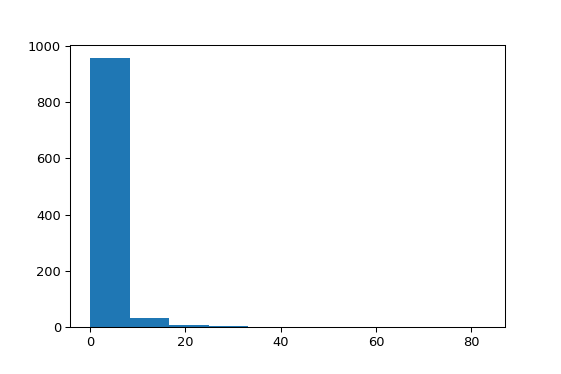

(array([ 956.,   32.,    7.,    3.,    1.,    0.,    0.,    0.,    0.,    1.]),
 array([  2.36686875e-02,   8.32326030e+00,   1.66228519e+01,
          2.49224435e+01,   3.32220352e+01,   4.15216268e+01,
          4.98212184e+01,   5.81208100e+01,   6.64204016e+01,
          7.47199932e+01,   8.30195848e+01]),
 <a list of 10 Patch objects>)

In [4]:
# plt.hist(np.random.lognormal(0,1.3,1000))

In [13]:
np.random.randint(2)

1